# Book chapter - PCA2+K-Means++ - Scenario 1 - Full features

# 1. Import

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from time import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.metrics import *
import seaborn as sns
sns.set()

In [4]:
!pip install ipython-autotime

%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 8.59 s


In [5]:
from google.colab import files
uploaded = files.upload()

Saving dataset_joined.csv to dataset_joined (1).csv
time: 1min 5s


## Read CSV

In [6]:
df = pd.read_csv('dataset_joined.csv', sep=',', encoding = "ISO-8859-1")

time: 126 ms


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10,11,12,13,14,15,23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Verify import

In [7]:
df.head()

,UniqueIDDataset,UniqueIDRow,SCLink,System,Temperature,TemperatureHumid,RelativeHumidity,WindDirection,WindVelocity,LotNumber,Acetochlor,Atrazine,Ciat,Ceat,Dimethenamid,Stage,Defoliation,Reproductive,Bolls,Height,Nodes,Weight,Yield,BatchNumber,Destination,Defective,MeanSignalStrength,StdSignalStrength,MeanLinkQuality,StdLinkQuality,MeanNoiseFloor,StdNoiseFloor,StdTemperature,StdRH,Machine,pCutTorque,pCutLagError,pCutActualPosition,pCutActualSpeed,pSvolFilmActualPosition,pSvolFilmActualSpeed,pSvolFilmLagError
0,1,1,Farm,2,24.4,22.4,84.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2,Farm,2,22.9,21.5,88.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,3,Farm,2,26.6,23.3,75.0,5.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,4,Farm,2,22.6,21.4,89.0,36.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,5,Farm,2,22.4,21.3,90.0,36.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


time: 91.6 ms


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36351 entries, 0 to 36350
Data columns (total 42 columns):
UniqueIDDataset            36351 non-null int64
UniqueIDRow                36351 non-null int64
SCLink                     36351 non-null object
System                     36351 non-null int64
Temperature                22489 non-null float64
TemperatureHumid           19175 non-null float64
RelativeHumidity           23149 non-null float64
WindDirection              20520 non-null float64
WindVelocity               20518 non-null float64
LotNumber                  1537 non-null float64
Acetochlor                 184 non-null object
Atrazine                   184 non-null object
Ciat                       184 non-null object
Ceat                       184 non-null object
Dimethenamid               184 non-null object
Stage                      250 non-null object
Defoliation                250 non-null float64
Reproductive               250 non-null float64
Bolls                

In [9]:
df.describe()

,UniqueIDDataset,UniqueIDRow,System,Temperature,TemperatureHumid,RelativeHumidity,WindDirection,WindVelocity,LotNumber,Defoliation,Reproductive,Bolls,Height,Nodes,Weight,Yield,Destination,Defective,MeanSignalStrength,StdSignalStrength,MeanLinkQuality,StdLinkQuality,MeanNoiseFloor,StdNoiseFloor,StdTemperature,StdRH,Machine,pCutTorque,pCutLagError,pCutActualPosition,pCutActualSpeed,pSvolFilmActualPosition,pSvolFilmActualSpeed,pSvolFilmLagError
count,36351.000000,36351.000000,36351.000000,22489.000000,19175.000000,23149.000000,20520.000000,20518.000000,1537.000000,250.000000,250.000000,250.000000,250.000000,250.000000,125.000000,432.00000,671.000000,465.000000,1998.000000,1999.000000,1998.000000,1998.000000,1998.000000,1997.000000,1998.000000,1998.000000,14287.000000,12288.000000,12288.000000,12288.000000,12288.000000,12288.000000,12288.000000,12288.000000
mean,3.431487,7938.134384,2.398393,24.040672,19.498154,62.482943,15.553655,1.993545,105.464541,50.000000,4.112000,3.912000,69.224000,14.908000,25.779840,496.11331,1.527571,14.532129,-86.147292,2.796471,96.946765,20.736383,-95.416907,36.649044,0.022839,0.055271,3.780150,-0.113236,0.000012,-835919.878337,886.997007,46516.192464,1373.244194,0.634156
std,2.840264,5779.083632,0.525929,4.256546,2.763787,21.374480,12.488792,1.650432,106.291708,35.426263,1.149234,1.292648,8.276947,1.761804,6.831864,415.67746,0.499612,6.041447,10.161517,16.187693,3.717591,17.168584,3.078773,86.948962,0.040996,0.262014,2.035875,0.408600,0.038929,29288.666806,1295.032421,32570.780305,631.174696,0.114129
min,1.000000,1.000000,1.000000,8.400000,1.700000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,43.000000,10.000000,4.735000,10.17000,1.000000,6.000000,-92.500000,0.000000,85.500000,0.585600,-109.290000,0.000000,0.004285,0.000000,1.000000,-2.843960,-0.599982,-884747.000000,-954.437256,11127.000000,-25.043488,-0.086025
25%,1.000000,2776.500000,2.000000,21.200000,17.700000,48.000000,5.000000,1.000000,30.000000,25.000000,3.000000,3.000000,63.000000,14.000000,22.560000,182.07500,1.000000,9.700000,-89.542000,0.451390,94.525250,8.459175,-97.333000,0.421910,0.011037,0.015378,2.000000,-0.344438,-0.009893,-852347.000000,-127.029419,19583.250000,736.276001,0.610809
50%,1.000000,7320.000000,2.000000,23.500000,20.100000,64.000000,14.000000,2.000000,67.000000,50.000000,4.000000,4.000000,70.000000,15.000000,26.994000,339.88500,2.000000,13.250000,-88.752500,1.007900,97.021500,14.251500,-96.000000,4.918000,0.014945,0.020292,4.000000,-0.183299,-0.000074,-838818.000000,497.817993,35097.000000,1392.412964,0.653197
75%,7.000000,11864.000000,3.000000,27.000000,21.500000,80.000000,27.000000,3.000000,149.000000,75.000000,5.000000,5.000000,74.875000,16.000000,30.010000,728.58500,2.000000,17.800000,-88.021000,1.483000,98.872000,30.007000,-94.150250,52.381000,0.021213,0.029886,5.000000,0.292760,0.010476,-816100.500000,1991.271973,67492.750000,2003.471802,0.692448
max,7.000000,20527.000000,3.000000,38.800000,30.000000,100.000000,36.000000,17.000000,432.000000,100.000000,8.000000,8.000000,92.000000,20.000000,38.320000,2037.63000,2.000000,57.500000,-17.212000,377.350000,107.150000,168.580000,-85.082000,1867.900000,0.584290,4.739800,10.000000,0.632072,0.367500,-783498.000000,3570.556641,113597.000000,2742.251953,0.962216


time: 167 ms


# 2. Dataprep

## Transform to numbers

In [10]:
#def extractValues(df, categoryName, categoryMap):
#    categories = df[categoryName]
#    numCat = categories.map(categoryMap)
#    data = df.drop(columns=categoryName)
    
    #return data, numCat

def dropColumns(data, columns):
    for col in columns:
        data = data.drop(columns=col)  
        
    return data
    
def fillNans(data, strategy):
    if strategy=='ZERO':
        data = data.fillna(0)
    elif strategy=='MIN':
        data = data.fillna(-999)
    elif strategy=='MAX':
        data = data.fillna(999)
    elif strategy=='INTER':
        data = data.interpolate(method='linear', limit_direction='backward', axis=0)
        data = data.interpolate(method='linear', limit_direction='forward', axis=0)

    return data

time: 9.11 ms


## Fix acetochlor

In [11]:
df.Acetochlor.replace(to_replace="<.05", value=0.05, inplace=True)

time: 12.1 ms


In [12]:
df["AcetocNum"] = pd.to_numeric(df['Acetochlor'])

time: 11.2 ms


## Fix stage

In [13]:
le = preprocessing.LabelEncoder()

time: 4.46 ms


In [14]:
df['Stage'].fillna("nan",inplace=True)

time: 7.41 ms


In [15]:
df['Stage'].unique()

array(['nan', 'vegetative', 'flowerbud', 'blossom', 'boll', 'bollopen'],
      dtype=object)

time: 6.94 ms


In [16]:
le.fit(df['Stage'])

LabelEncoder()

time: 6.37 ms


In [17]:
le.classes_

array(['blossom', 'boll', 'bollopen', 'flowerbud', 'nan', 'vegetative'],
      dtype=object)

time: 3.49 ms


In [18]:
df['StageNum'] = le.transform(df['Stage'])

time: 12.4 ms


In [19]:
df['StageNum'].unique()

array([4, 5, 3, 0, 1, 2])

time: 5.06 ms


## Fix sclink number

In [20]:
le3 = preprocessing.LabelEncoder()

time: 1.1 ms


In [21]:
df['SCLinkNum'] = le3.fit_transform(df['SCLink'])

time: 15.1 ms


In [22]:
df.head()

,UniqueIDDataset,UniqueIDRow,SCLink,System,Temperature,TemperatureHumid,RelativeHumidity,WindDirection,WindVelocity,LotNumber,Acetochlor,Atrazine,Ciat,Ceat,Dimethenamid,Stage,Defoliation,Reproductive,Bolls,Height,Nodes,Weight,Yield,BatchNumber,Destination,Defective,MeanSignalStrength,StdSignalStrength,MeanLinkQuality,StdLinkQuality,MeanNoiseFloor,StdNoiseFloor,StdTemperature,StdRH,Machine,pCutTorque,pCutLagError,pCutActualPosition,pCutActualSpeed,pSvolFilmActualPosition,pSvolFilmActualSpeed,pSvolFilmLagError,AcetocNum,StageNum,SCLinkNum
0,1,1,Farm,2,24.4,22.4,84.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,0
1,1,2,Farm,2,22.9,21.5,88.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,0
2,1,3,Farm,2,26.6,23.3,75.0,5.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,0
3,1,4,Farm,2,22.6,21.4,89.0,36.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,0
4,1,5,Farm,2,22.4,21.3,90.0,36.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,0


time: 105 ms


## Fix batch number

In [23]:
le2 = preprocessing.LabelEncoder()

time: 1.06 ms


In [24]:
df['BatchNumber'].fillna("nan",inplace=True)

time: 7.2 ms


In [25]:
df['BatchNumber'].unique()

array(['nan', '8553FA02', '7162EG01', '4819CJ01', '8581FK05', '5066FL01',
       '7858GP03', '1609GN01', '9566GC01', '7922GR01', '9534EO01',
       '3625CF01', '1424FK01', '378FK01', '7375CB01', '7796EK03',
       '8361EH01', '8010EJ03', '2081GA03', '3876EX01', '8728EL02',
       '1074FL01', '2344FP01', '2480FH01', '4840FR01', '6330FT02',
       '487GH01', '8438CG03', '804FK01', '9592EG01', '6960CT03',
       '3063EV01', '4643FK02', '5238FK01', '6866GL01', '1929FR03',
       '5920FF01', '2328FG03', '2203FS01', '1623FS01', '2441FP01',
       '3063EU01', '4623EZ01', '6612FJ03', '1557GC01', '2256EN01',
       '2371CE04', '8020EJ03', '3756EY01', '972FP02', '9621FL02',
       '9750FN01', '6091EH01', '5869FB01', '5691FN01', '7323FA01',
       '1423FK01', '9FE01', '2182CU03', '6312GC01', '3063GC01',
       '9275GC01', '6573GL01', '2739FL01', '2773BH01', '1437FK01',
       '1256FL01', '6392EJ01', '7066EU02', '6692CB01', '5366EQ01',
       '8581FK03', '2666FG03', '8010EJ01', '6116FP01', '7356CL

time: 8.15 ms


In [26]:
le2.fit(df['BatchNumber'])

LabelEncoder()

time: 5.23 ms


In [27]:
le2.classes_

array(['1009GS01', '1073FL01', '1073GS01', '1074FL01', '1086FK02',
       '1131FJ01', '11JG8350', '122CG01', '1256FL01', '1277GA01',
       '1379FT01', '1423FK01', '1424FK01', '142FK01', '1437FK01',
       '1440ET02', '1450FG01', '1450GU01', '1522GN01', '1557GC01',
       '15FC06', '1609GN01', '1623FS01', '1735HH07', '1740HH01',
       '1740HH07', '1757GV02', '1802FY01', '1846FG01', '1929FR03',
       '1934CK09', '1986FK01', '1987GF01', '2013GP01', '2023HH07',
       '2025HH07', '2027HH07', '2081GA03', '209FC01', '2116FG02',
       '217EJ04', '2182CU03', '2203FS01', '220FT01', '2256EN01',
       '2283EY01', '2301FS01', '2305BC01', '2325FP01', '2328FG03',
       '2341FP01', '2342FP01', '2344FP01', '2345EG01', '2371CE04',
       '2441FP01', '2455EJ01', '2473FE01', '2480FH01', '2535FP01',
       '2658AI01', '2659GP01', '2665FG01', '2665FG03', '2666FG01',
       '2666FG02', '2666FG03', '2666fg03', '269EG02', '269EJ02',
       '2739FL01', '2766FL07', '2773BH01', '2951GY01', '2984EN01',
    

time: 5.67 ms


In [28]:
df['BatchNum'] = le2.transform(df['BatchNumber'])

time: 12.3 ms


In [29]:
df['BatchNum'].unique()

array([275, 238, 190, 127, 242, 137, 214,  21, 259, 216, 258,  86,  12,
        89, 197, 210, 234, 219,  37,  93, 247,   3,  52,  58, 129, 167,
       132, 235, 223, 260, 183,  77, 122, 140, 181,  29, 155,  49,  42,
        22,  55,  76, 121, 175,  19,  44,  54, 221,  88, 265, 262, 268,
       159, 154, 150, 193,  11, 274,  41, 165,  78, 253, 174,  70,  72,
        14,   8, 170, 187, 177, 142, 241,  66, 218, 162, 195,  56, 209,
        32,  80, 217,  94, 115, 135,  20, 164, 136,  43, 246, 130,  51,
        84, 191, 194, 123, 206,  79, 248,  27, 236, 232,  71, 243, 103,
         4,  45, 254, 224, 213, 118, 188, 245,  57, 227,  81, 143, 239,
        31, 124, 173, 255, 180,  30,   6, 189, 100, 249,  97, 138, 228,
       240,   7,  68, 203, 117, 270, 178, 101, 233,  83, 147, 273,  73,
        16, 192, 120, 144,  46, 119, 146, 244, 116, 149,  62, 108, 231,
        75,  53,  74, 272,  63,   5, 215, 104, 257, 114, 182, 264,  38,
        98,  91,  48, 109, 153,  15,  82, 201, 237, 212, 269, 16

time: 7.09 ms


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36351 entries, 0 to 36350
Data columns (total 46 columns):
UniqueIDDataset            36351 non-null int64
UniqueIDRow                36351 non-null int64
SCLink                     36351 non-null object
System                     36351 non-null int64
Temperature                22489 non-null float64
TemperatureHumid           19175 non-null float64
RelativeHumidity           23149 non-null float64
WindDirection              20520 non-null float64
WindVelocity               20518 non-null float64
LotNumber                  1537 non-null float64
Acetochlor                 184 non-null object
Atrazine                   184 non-null object
Ciat                       184 non-null object
Ceat                       184 non-null object
Dimethenamid               184 non-null object
Stage                      36351 non-null object
Defoliation                250 non-null float64
Reproductive               250 non-null float64
Bolls              

## Drop text columns

In [31]:
columns = ["SCLink","UniqueIDDataset","UniqueIDRow","System","Atrazine","Ciat","Ceat","Dimethenamid","Acetochlor","Stage","BatchNumber","SCLinkNum"]
data = dropColumns(df, columns)

time: 74.8 ms


## Remove nans

In [32]:
data = fillNans(data, "ZERO")

time: 10.2 ms


In [33]:
data.head()

,Temperature,TemperatureHumid,RelativeHumidity,WindDirection,WindVelocity,LotNumber,Defoliation,Reproductive,Bolls,Height,Nodes,Weight,Yield,Destination,Defective,MeanSignalStrength,StdSignalStrength,MeanLinkQuality,StdLinkQuality,MeanNoiseFloor,StdNoiseFloor,StdTemperature,StdRH,Machine,pCutTorque,pCutLagError,pCutActualPosition,pCutActualSpeed,pSvolFilmActualPosition,pSvolFilmActualSpeed,pSvolFilmLagError,AcetocNum,StageNum,BatchNum
0,24.4,22.4,84.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,275
1,22.9,21.5,88.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,275
2,26.6,23.3,75.0,5.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,275
3,22.6,21.4,89.0,36.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,275
4,22.4,21.3,90.0,36.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,275


time: 66.5 ms


In [34]:
data.columns

Index(['Temperature', 'TemperatureHumid', 'RelativeHumidity', 'WindDirection',
       'WindVelocity', 'LotNumber', 'Defoliation', 'Reproductive', 'Bolls',
       'Height', 'Nodes', 'Weight', 'Yield', 'Destination', 'Defective',
       'MeanSignalStrength', 'StdSignalStrength', 'MeanLinkQuality',
       'StdLinkQuality', 'MeanNoiseFloor', 'StdNoiseFloor', 'StdTemperature',
       'StdRH', 'Machine', 'pCutTorque', 'pCutLagError', 'pCutActualPosition',
       'pCutActualSpeed', 'pSvolFilmActualPosition', 'pSvolFilmActualSpeed',
       'pSvolFilmLagError', 'AcetocNum', 'StageNum', 'BatchNum'],
      dtype='object')

time: 4.39 ms


## Scale data

In [35]:
scaler = StandardScaler()

time: 1.88 ms


In [36]:
data = pd.DataFrame(scaler.fit_transform(data), columns= data.columns)

time: 44.4 ms


In [37]:
data.head()

,Temperature,TemperatureHumid,RelativeHumidity,WindDirection,WindVelocity,LotNumber,Defoliation,Reproductive,Bolls,Height,Nodes,Weight,Yield,Destination,Defective,MeanSignalStrength,StdSignalStrength,MeanLinkQuality,StdLinkQuality,MeanNoiseFloor,StdNoiseFloor,StdTemperature,StdRH,Machine,pCutTorque,pCutLagError,pCutActualPosition,pCutActualSpeed,pSvolFilmActualPosition,pSvolFilmActualSpeed,pSvolFilmLagError,AcetocNum,StageNum,BatchNum
0,0.784279,1.218901,1.279492,-0.722900,-0.709612,-0.146399,-0.067868,-0.080137,-0.079004,-0.082626,-0.08264,-0.05679,-0.083894,-0.130232,-0.105027,0.239411,-0.039961,-0.240978,-0.18362,0.241033,-0.091436,-0.114869,-0.048458,-0.661933,0.157187,-0.000177,0.713943,-0.347866,-0.541648,-0.622194,-0.69774,-0.025228,0.060058,0.12105
1,0.660796,1.128350,1.395258,-0.722900,-0.709612,-0.146399,-0.067868,-0.080137,-0.079004,-0.082626,-0.08264,-0.05679,-0.083894,-0.130232,-0.105027,0.239411,-0.039961,-0.240978,-0.18362,0.241033,-0.091436,-0.114869,-0.048458,-0.661933,0.157187,-0.000177,0.713943,-0.347866,-0.541648,-0.622194,-0.69774,-0.025228,0.060058,0.12105
2,0.965388,1.309452,1.019019,-0.311225,1.182286,-0.146399,-0.067868,-0.080137,-0.079004,-0.082626,-0.08264,-0.05679,-0.083894,-0.130232,-0.105027,0.239411,-0.039961,-0.240978,-0.18362,0.241033,-0.091436,-0.114869,-0.048458,-0.661933,0.157187,-0.000177,0.713943,-0.347866,-0.541648,-0.622194,-0.69774,-0.025228,0.060058,0.12105
3,0.636099,1.118288,1.424200,2.241163,0.551653,-0.146399,-0.067868,-0.080137,-0.079004,-0.082626,-0.08264,-0.05679,-0.083894,-0.130232,-0.105027,0.239411,-0.039961,-0.240978,-0.18362,0.241033,-0.091436,-0.114869,-0.048458,-0.661933,0.157187,-0.000177,0.713943,-0.347866,-0.541648,-0.622194,-0.69774,-0.025228,0.060058,0.12105
4,0.619634,1.108227,1.453141,2.241163,1.812918,-0.146399,-0.067868,-0.080137,-0.079004,-0.082626,-0.08264,-0.05679,-0.083894,-0.130232,-0.105027,0.239411,-0.039961,-0.240978,-0.18362,0.241033,-0.091436,-0.114869,-0.048458,-0.661933,0.157187,-0.000177,0.713943,-0.347866,-0.541648,-0.622194,-0.69774,-0.025228,0.060058,0.12105


time: 64.2 ms


In [38]:
data.columns

Index(['Temperature', 'TemperatureHumid', 'RelativeHumidity', 'WindDirection',
       'WindVelocity', 'LotNumber', 'Defoliation', 'Reproductive', 'Bolls',
       'Height', 'Nodes', 'Weight', 'Yield', 'Destination', 'Defective',
       'MeanSignalStrength', 'StdSignalStrength', 'MeanLinkQuality',
       'StdLinkQuality', 'MeanNoiseFloor', 'StdNoiseFloor', 'StdTemperature',
       'StdRH', 'Machine', 'pCutTorque', 'pCutLagError', 'pCutActualPosition',
       'pCutActualSpeed', 'pSvolFilmActualPosition', 'pSvolFilmActualSpeed',
       'pSvolFilmLagError', 'AcetocNum', 'StageNum', 'BatchNum'],
      dtype='object')

time: 3.65 ms


## Create full features scenarios (all features) - sc1

## sc1 inputs

In [39]:
dfsc1 = data[['Temperature', 'TemperatureHumid', 'RelativeHumidity', 'WindDirection',
       'WindVelocity', 'LotNumber', 'Defoliation', 'Reproductive', 'Bolls',
       'Height', 'Nodes', 'Weight', 'Yield', 'Destination', 'Defective',
       'MeanSignalStrength', 'StdSignalStrength', 'MeanLinkQuality',
       'StdLinkQuality', 'MeanNoiseFloor', 'StdNoiseFloor', 'StdTemperature',
       'StdRH', 'Machine', 'pCutTorque', 'pCutLagError', 'pCutActualPosition',
       'pCutActualSpeed', 'pSvolFilmActualPosition', 'pSvolFilmActualSpeed',
       'pSvolFilmLagError', 'AcetocNum', 'StageNum', 'BatchNum']].copy()

time: 21.5 ms


In [40]:
dfsc1.head()

,Temperature,TemperatureHumid,RelativeHumidity,WindDirection,WindVelocity,LotNumber,Defoliation,Reproductive,Bolls,Height,Nodes,Weight,Yield,Destination,Defective,MeanSignalStrength,StdSignalStrength,MeanLinkQuality,StdLinkQuality,MeanNoiseFloor,StdNoiseFloor,StdTemperature,StdRH,Machine,pCutTorque,pCutLagError,pCutActualPosition,pCutActualSpeed,pSvolFilmActualPosition,pSvolFilmActualSpeed,pSvolFilmLagError,AcetocNum,StageNum,BatchNum
0,0.784279,1.218901,1.279492,-0.722900,-0.709612,-0.146399,-0.067868,-0.080137,-0.079004,-0.082626,-0.08264,-0.05679,-0.083894,-0.130232,-0.105027,0.239411,-0.039961,-0.240978,-0.18362,0.241033,-0.091436,-0.114869,-0.048458,-0.661933,0.157187,-0.000177,0.713943,-0.347866,-0.541648,-0.622194,-0.69774,-0.025228,0.060058,0.12105
1,0.660796,1.128350,1.395258,-0.722900,-0.709612,-0.146399,-0.067868,-0.080137,-0.079004,-0.082626,-0.08264,-0.05679,-0.083894,-0.130232,-0.105027,0.239411,-0.039961,-0.240978,-0.18362,0.241033,-0.091436,-0.114869,-0.048458,-0.661933,0.157187,-0.000177,0.713943,-0.347866,-0.541648,-0.622194,-0.69774,-0.025228,0.060058,0.12105
2,0.965388,1.309452,1.019019,-0.311225,1.182286,-0.146399,-0.067868,-0.080137,-0.079004,-0.082626,-0.08264,-0.05679,-0.083894,-0.130232,-0.105027,0.239411,-0.039961,-0.240978,-0.18362,0.241033,-0.091436,-0.114869,-0.048458,-0.661933,0.157187,-0.000177,0.713943,-0.347866,-0.541648,-0.622194,-0.69774,-0.025228,0.060058,0.12105
3,0.636099,1.118288,1.424200,2.241163,0.551653,-0.146399,-0.067868,-0.080137,-0.079004,-0.082626,-0.08264,-0.05679,-0.083894,-0.130232,-0.105027,0.239411,-0.039961,-0.240978,-0.18362,0.241033,-0.091436,-0.114869,-0.048458,-0.661933,0.157187,-0.000177,0.713943,-0.347866,-0.541648,-0.622194,-0.69774,-0.025228,0.060058,0.12105
4,0.619634,1.108227,1.453141,2.241163,1.812918,-0.146399,-0.067868,-0.080137,-0.079004,-0.082626,-0.08264,-0.05679,-0.083894,-0.130232,-0.105027,0.239411,-0.039961,-0.240978,-0.18362,0.241033,-0.091436,-0.114869,-0.048458,-0.661933,0.157187,-0.000177,0.713943,-0.347866,-0.541648,-0.622194,-0.69774,-0.025228,0.060058,0.12105


time: 70.7 ms


In [41]:
dfsc1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36351 entries, 0 to 36350
Data columns (total 34 columns):
Temperature                36351 non-null float64
TemperatureHumid           36351 non-null float64
RelativeHumidity           36351 non-null float64
WindDirection              36351 non-null float64
WindVelocity               36351 non-null float64
LotNumber                  36351 non-null float64
Defoliation                36351 non-null float64
Reproductive               36351 non-null float64
Bolls                      36351 non-null float64
Height                     36351 non-null float64
Nodes                      36351 non-null float64
Weight                     36351 non-null float64
Yield                      36351 non-null float64
Destination                36351 non-null float64
Defective                  36351 non-null float64
MeanSignalStrength         36351 non-null float64
StdSignalStrength          36351 non-null float64
MeanLinkQuality            36351 non-null

## Create less features scenarios (less features) - sc2

## sc2 inputs

In [42]:
#- Features que não precisariam ser consideradas no modelo, mas estão sendo consideradas 
# (não é um problema, mas vou tentar rodar sem pra ver o que acontece): 
# TemperatureHumid, WindDirection, WindVerlocity, Reproductive, Bolls, Height, Nodes, Weight, 
# Defective, MeanSignalStrength, StdSignalStrength, MeanLinkQuality, StdLinkQuality, StdTemperature, 
# stdRH, pCutActualPosition, pCutActualSpeed, pSvolFilmActualPosition, pSvolFilmActualSpeed e pSvolFilmeLagError

time: 905 µs


In [43]:
dfsc2 = data[['Temperature', 'RelativeHumidity','LotNumber', 'Defoliation',
              'Yield', 'Destination','MeanNoiseFloor', 'StdNoiseFloor','Machine',
              'pCutTorque', 'pCutLagError','AcetocNum', 'StageNum', 'BatchNum']].copy()

time: 13.6 ms


In [44]:
dfsc2.head()

,Temperature,RelativeHumidity,LotNumber,Defoliation,Yield,Destination,MeanNoiseFloor,StdNoiseFloor,Machine,pCutTorque,pCutLagError,AcetocNum,StageNum,BatchNum
0,0.784279,1.279492,-0.146399,-0.067868,-0.083894,-0.130232,0.241033,-0.091436,-0.661933,0.157187,-0.000177,-0.025228,0.060058,0.12105
1,0.660796,1.395258,-0.146399,-0.067868,-0.083894,-0.130232,0.241033,-0.091436,-0.661933,0.157187,-0.000177,-0.025228,0.060058,0.12105
2,0.965388,1.019019,-0.146399,-0.067868,-0.083894,-0.130232,0.241033,-0.091436,-0.661933,0.157187,-0.000177,-0.025228,0.060058,0.12105
3,0.636099,1.424200,-0.146399,-0.067868,-0.083894,-0.130232,0.241033,-0.091436,-0.661933,0.157187,-0.000177,-0.025228,0.060058,0.12105
4,0.619634,1.453141,-0.146399,-0.067868,-0.083894,-0.130232,0.241033,-0.091436,-0.661933,0.157187,-0.000177,-0.025228,0.060058,0.12105


time: 32.9 ms


## Targets

In [45]:
target_system = df[['System']].copy()

time: 4.59 ms


In [46]:
target_system.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36351 entries, 0 to 36350
Data columns (total 1 columns):
System    36351 non-null int64
dtypes: int64(1)
memory usage: 284.1 KB
time: 8.99 ms


In [47]:
target_system.head()

,System
0,2
1,2
2,2
3,2
4,2


time: 14.2 ms


In [48]:
target_sclink = df[['SCLinkNum']]

time: 3.25 ms


In [49]:
target_sclink.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36351 entries, 0 to 36350
Data columns (total 1 columns):
SCLinkNum    36351 non-null int64
dtypes: int64(1)
memory usage: 284.1 KB
time: 10 ms


In [50]:
target_sclink.head()

,SCLinkNum
0,0
1,0
2,0
3,0
4,0


time: 20.7 ms


In [51]:
dfsc1 = PCA(n_components=2).fit_transform(dfsc1)

time: 172 ms


# 3. Model building and implementation

## SC1 with target = system

## Model building with 3 clusters (optimal answer)

In [52]:
target_system.System.value_counts()

2    20527
3    15153
1      671
Name: System, dtype: int64

time: 9.91 ms


In [53]:
%%time
kmeansc1pp3 = KMeans(n_clusters=3, random_state=42).fit(dfsc1)

CPU times: user 186 ms, sys: 122 ms, total: 307 ms
Wall time: 164 ms
time: 167 ms


In [54]:
kmeansc1pp3.labels_

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

time: 4.69 ms


In [55]:
sc1pp3labels = pd.Series(kmeansc1pp3.labels_)

time: 1.97 ms


In [56]:
sc1pp3labels.value_counts()

0    23813
1    12288
2      250
dtype: int64

time: 11.7 ms


In [57]:
cmpp3 = confusion_matrix(target_system.System, sc1pp3labels)

time: 70.9 ms


In [58]:
cmpp3

array([[    0,     0,     0,     0],
       [  671,     0,     0,     0],
       [20527,     0,     0,     0],
       [ 2615, 12288,   250,     0]])

time: 5.26 ms


## Check correct labels

Text(30.5, 0.5, 'True')

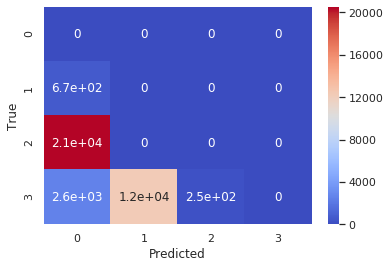

time: 287 ms


In [59]:
sns.heatmap(cmpp3,annot=True,cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('True')

## Change to correct labels

In [60]:
labelspp3 = kmeansc1pp3.labels_
labelspp3[labelspp3 == 0] = 4
labelspp3[labelspp3 == 1] = 5
labelspp3[labelspp3 == 2] = 6

time: 3.29 ms


In [61]:
labelspp3[labelspp3 == 4] = 2
labelspp3[labelspp3 == 5] = 3
labelspp3[labelspp3 == 6] = 1

time: 3.34 ms


## Check heatmap

In [62]:
cmpp3 = confusion_matrix(target_system, labelspp3)

time: 39.2 ms


Text(30.5, 0.5, 'True')

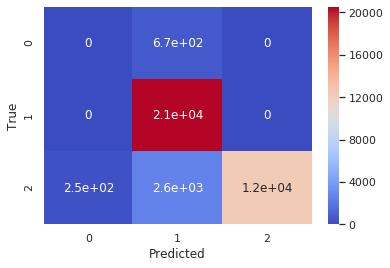

time: 263 ms


In [63]:
sns.heatmap(cmpp3,annot=True,cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('True')

In [64]:
reportpp3 = classification_report(target_system, labelspp3,output_dict = True)

time: 41.6 ms


In [65]:
reportpp3

{'1': {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0, 'support': 671},
 '2': {'f1-score': 0.9258908434821831,
  'precision': 0.8620081468105657,
  'recall': 1.0,
  'support': 20527},
 '3': {'f1-score': 0.895594183885427,
  'precision': 1.0,
  'recall': 0.8109285290041576,
  'support': 15153},
 'accuracy': 0.9027261973535804,
 'macro avg': {'f1-score': 0.6071616757892033,
  'precision': 0.6206693822701886,
  'recall': 0.6036428430013858,
  'support': 36351},
 'weighted avg': {'f1-score': 0.8961706696535073,
  'precision': 0.9036186412913119,
  'recall': 0.9027261973535804,
  'support': 36351}}

time: 5.53 ms


## Calculating the elbow method (optimal number of clusters)

In [66]:
wcss =[]
for i in range(1,30):
  kmeanModel = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
  kmeanModel.fit(dfsc1)
  wcss.append(kmeanModel.inertia_)

time: 33.4 s


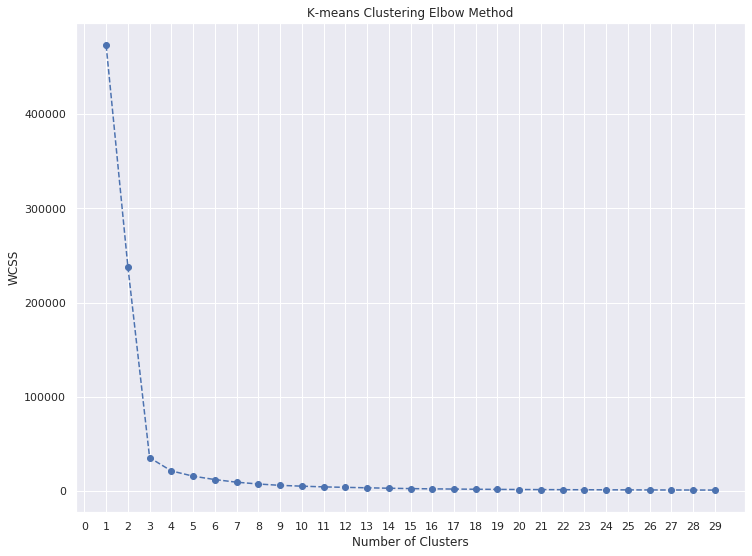

time: 441 ms


In [67]:
plt.figure(figsize=(12,9))
plt.plot(range(1,30),wcss,marker='o',linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.xticks(np.arange(0, 30, 1))
plt.title('K-means Clustering Elbow Method')
plt.show()

## Results analysis

In [68]:
print("Confusion matrix\n",metrics.confusion_matrix(y_true=target_system.System,y_pred=labelspp3)) 
print("Classification report\n",metrics.classification_report(y_true=target_system.System,y_pred=labelspp3)) 

Confusion matrix
 [[    0   671     0]
 [    0 20527     0]
 [  250  2615 12288]]
Classification report
               precision    recall  f1-score   support

           1       0.00      0.00      0.00       671
           2       0.86      1.00      0.93     20527
           3       1.00      0.81      0.90     15153

    accuracy                           0.90     36351
   macro avg       0.62      0.60      0.61     36351
weighted avg       0.90      0.90      0.90     36351

time: 78.6 ms


In [69]:
print('\033[1m'+"Kmeans++:"+'\033[0m')
print('\033[1m'+"System 1"+'\033[0m')
print("Precision = {0:0.3f}".format(reportpp3["1"]["precision"]))
print("Recall = {0:0.3f}".format(reportpp3["1"]["recall"]))
print("F1-score = {0:0.3f}".format(reportpp3["1"]["f1-score"]))
print("Support = {0:0.3f}".format(reportpp3["1"]["support"]))
print('\033[1m'+"System 2"+'\033[0m')
print("Precision = {0:0.3f}".format(reportpp3["2"]["precision"]))
print("Recall = {0:0.3f}".format(reportpp3["2"]["recall"]))
print("F1-score = {0:0.3f}".format(reportpp3["2"]["f1-score"]))
print("Support = {0:0.3f}".format(reportpp3["2"]["support"]))
print('\033[1m'+"System 3"+'\033[0m')
print("Precision = {0:0.3f}".format(reportpp3["3"]["precision"]))
print("Recall = {0:0.3f}".format(reportpp3["3"]["recall"]))
print("F1-score = {0:0.3f}".format(reportpp3["3"]["f1-score"]))
print("Support = {0:0.3f}".format(reportpp3["3"]["support"]))

Kmeans++:
System 1
Precision = 0.000
Recall = 0.000
F1-score = 0.000
Support = 671.000
System 2
Precision = 0.862
Recall = 1.000
F1-score = 0.926
Support = 20527.000
System 3
Precision = 1.000
Recall = 0.811
F1-score = 0.896
Support = 15153.000
time: 15.5 ms


In [70]:
print('\033[1m'+'Clustering metrics - supervised'+'\033[0m')
print('Adjusted Rand score: ', metrics.adjusted_rand_score(target_system.System, labelspp3))
print('Mutual info score: ', metrics.adjusted_mutual_info_score(target_system.System, labelspp3))
print('Homogeneity score: ', metrics.homogeneity_score(target_system.System, labelspp3))
print('Completeness score: ', metrics.completeness_score(target_system.System, labelspp3))
print('V-measure: ', metrics.v_measure_score(target_system.System, labelspp3))
print('Fowlkes-Mallows score: ', metrics.fowlkes_mallows_score(target_system.System, labelspp3))

Clustering metrics - supervised
Adjusted Rand score:  0.6823361077431518
Mutual info score:  0.6288415438002335
Homogeneity score:  0.5945082951466247
Completeness score:  0.6674481883802669
V-measure:  0.6288703132831919
Fowlkes-Mallows score:  0.8475658942266868
time: 71.7 ms


In [71]:
print('\033[1m'+'Clustering metrics - unsupervised'+'\033[0m')
print('Silhouette: ',metrics.silhouette_score(dfsc1, labelspp3, metric='euclidean'))
print('Davies-Bouldin Index: ',metrics.davies_bouldin_score(dfsc1, labelspp3))
print('Calinski-Harabasz Index: ',metrics.calinski_harabaz_score(dfsc1, labelspp3))

Clustering metrics - unsupervised
Silhouette:  0.7988472575098736
Davies-Bouldin Index:  0.2191686775955013
Calinski-Harabasz Index:  226688.8900412993
time: 16.8 s


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=FutureWarning)


## Hyperparameter analysis: n_init

### 3 scenarios: 100, 300 and 500

### 01 - n_init = 100

In [72]:
kmeansc1pp3hyp1_01 = KMeans(n_clusters=3, random_state=42, n_init=100).fit(dfsc1)

time: 1.52 s


In [73]:
kmeansc1pp3hyp1_01.labels_

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

time: 4.91 ms


In [74]:
sc1pp3labelshyp1_01 = pd.Series(kmeansc1pp3hyp1_01.labels_)

time: 1.85 ms


In [75]:
sc1pp3labelshyp1_01.value_counts()

0    23813
1    12288
2      250
dtype: int64

time: 17.3 ms


In [76]:
cmpp3hyp1_01 = confusion_matrix(target_system.System, sc1pp3labelshyp1_01)

time: 59.2 ms


In [77]:
cmpp3hyp1_01

array([[    0,     0,     0,     0],
       [  671,     0,     0,     0],
       [20527,     0,     0,     0],
       [ 2615, 12288,   250,     0]])

time: 3.47 ms


## Check correct labels

Text(30.5, 0.5, 'True')

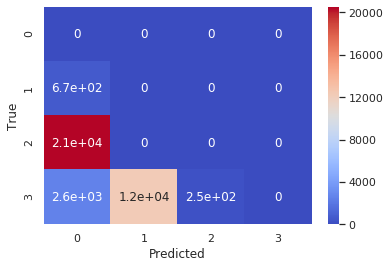

time: 272 ms


In [78]:
sns.heatmap(cmpp3hyp1_01,annot=True,cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('True')

## Change to correct labels

In [79]:
sc1pp3labelshyp1_01
sc1pp3labelshyp1_01[sc1pp3labelshyp1_01 == 0] = 4
sc1pp3labelshyp1_01[sc1pp3labelshyp1_01 == 1] = 5
sc1pp3labelshyp1_01[sc1pp3labelshyp1_01 == 2] = 6

time: 12.2 ms


In [80]:
sc1pp3labelshyp1_01[sc1pp3labelshyp1_01 == 4] = 2
sc1pp3labelshyp1_01[sc1pp3labelshyp1_01 == 5] = 1
sc1pp3labelshyp1_01[sc1pp3labelshyp1_01 == 6] = 3

time: 15.4 ms


## Check heatmap

In [81]:
cmpp3hyp1_01 = confusion_matrix(target_system.System, sc1pp3labelshyp1_01)

time: 36.4 ms


In [82]:
cmpp3hyp1_01

array([[    0,   671,     0],
       [    0, 20527,     0],
       [12288,  2615,   250]])

time: 3.97 ms


Text(30.5, 0.5, 'True')

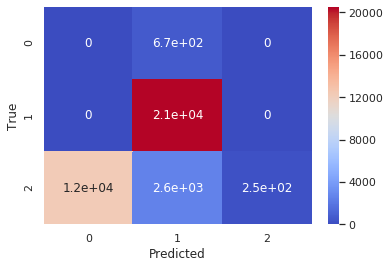

time: 246 ms


In [83]:
sns.heatmap(cmpp3hyp1_01,annot=True,cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('True')

In [84]:
reportpp3hyp1_01 = classification_report(target_system, sc1pp3labelshyp1_01,output_dict = True)

time: 46.3 ms


In [85]:
reportpp3hyp1_01

{'1': {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0, 'support': 671},
 '2': {'f1-score': 0.9258908434821831,
  'precision': 0.8620081468105657,
  'recall': 1.0,
  'support': 20527},
 '3': {'f1-score': 0.032461208855417784,
  'precision': 1.0,
  'recall': 0.016498383158450473,
  'support': 15153},
 'accuracy': 0.5715661192264312,
 'macro avg': {'f1-score': 0.31945068411253363,
  'precision': 0.6206693822701886,
  'recall': 0.33883279438615016,
  'support': 36351},
 'weighted avg': {'f1-score': 0.5363716553037032,
  'precision': 0.9036186412913119,
  'recall': 0.5715661192264312,
  'support': 36351}}

time: 4.36 ms


In [86]:
print("Confusion matrix\n",metrics.confusion_matrix(y_true=target_system.System,y_pred=sc1pp3labelshyp1_01)) 
print("Classification report\n",metrics.classification_report(y_true=target_system.System,y_pred=sc1pp3labelshyp1_01))

Confusion matrix
 [[    0   671     0]
 [    0 20527     0]
 [12288  2615   250]]
Classification report
               precision    recall  f1-score   support

           1       0.00      0.00      0.00       671
           2       0.86      1.00      0.93     20527
           3       1.00      0.02      0.03     15153

    accuracy                           0.57     36351
   macro avg       0.62      0.34      0.32     36351
weighted avg       0.90      0.57      0.54     36351

time: 86.3 ms


In [87]:
print('\033[1m'+"Kmeans++:"+'\033[0m')
print('\033[1m'+"System 1"+'\033[0m')
print("Precision = {0:0.3f}".format(reportpp3hyp1_01["1"]["precision"]))
print("Recall = {0:0.3f}".format(reportpp3hyp1_01["1"]["recall"]))
print("F1-score = {0:0.3f}".format(reportpp3hyp1_01["1"]["f1-score"]))
print("Support = {0:0.3f}".format(reportpp3hyp1_01["1"]["support"]))
print('\033[1m'+"System 2"+'\033[0m')
print("Precision = {0:0.3f}".format(reportpp3hyp1_01["2"]["precision"]))
print("Recall = {0:0.3f}".format(reportpp3hyp1_01["2"]["recall"]))
print("F1-score = {0:0.3f}".format(reportpp3hyp1_01["2"]["f1-score"]))
print("Support = {0:0.3f}".format(reportpp3hyp1_01["2"]["support"]))
print('\033[1m'+"System 3"+'\033[0m')
print("Precision = {0:0.3f}".format(reportpp3hyp1_01["3"]["precision"]))
print("Recall = {0:0.3f}".format(reportpp3hyp1_01["3"]["recall"]))
print("F1-score = {0:0.3f}".format(reportpp3hyp1_01["3"]["f1-score"]))
print("Support = {0:0.3f}".format(reportpp3hyp1_01["3"]["support"]))

Kmeans++:
System 1
Precision = 0.000
Recall = 0.000
F1-score = 0.000
Support = 671.000
System 2
Precision = 0.862
Recall = 1.000
F1-score = 0.926
Support = 20527.000
System 3
Precision = 1.000
Recall = 0.016
F1-score = 0.032
Support = 15153.000
time: 16.5 ms


In [88]:
print('\033[1m'+'Clustering metrics - supervised'+'\033[0m')
print('Adjusted Rand score: ', metrics.adjusted_rand_score(target_system.System, sc1pp3labelshyp1_01))
print('Mutual info score: ', metrics.adjusted_mutual_info_score(target_system.System, sc1pp3labelshyp1_01))
print('Homogeneity score: ', metrics.homogeneity_score(target_system.System, sc1pp3labelshyp1_01))
print('Completeness score: ', metrics.completeness_score(target_system.System, sc1pp3labelshyp1_01))
print('V-measure: ', metrics.v_measure_score(target_system.System, sc1pp3labelshyp1_01))
print('Fowlkes-Mallows score: ', metrics.fowlkes_mallows_score(target_system.System, sc1pp3labelshyp1_01))

Clustering metrics - supervised
Adjusted Rand score:  0.6823361077431518
Mutual info score:  0.6288415438002334
Homogeneity score:  0.5945082951466246
Completeness score:  0.6674481883802668
V-measure:  0.6288703132831915
Fowlkes-Mallows score:  0.8475658942266868
time: 68.1 ms


In [89]:
print('\033[1m'+'Clustering metrics - unsupervised'+'\033[0m')
print('Silhouette: ',metrics.silhouette_score(dfsc1, sc1pp3labelshyp1_01, metric='euclidean'))
print('Davies-Bouldin Index: ',metrics.davies_bouldin_score(dfsc1, sc1pp3labelshyp1_01))
print('Calinski-Harabasz Index: ',metrics.calinski_harabaz_score(dfsc1, sc1pp3labelshyp1_01))

Clustering metrics - unsupervised
Silhouette:  0.7988472575098736
Davies-Bouldin Index:  0.2191686775955013
Calinski-Harabasz Index:  226688.89004129928
time: 16.7 s


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=FutureWarning)


### 02 - n_init = 300

In [90]:
kmeansc1pp3hyp1_02 = KMeans(n_clusters=3, random_state=42, n_init=300).fit(dfsc1)

time: 4.68 s


In [91]:
kmeansc1pp3hyp1_02.labels_

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

time: 4.26 ms


In [92]:
sc1pp3labelshyp1_02 = pd.Series(kmeansc1pp3hyp1_02.labels_)

time: 2.7 ms


In [93]:
sc1pp3labelshyp1_02.value_counts()

0    23813
1    12288
2      250
dtype: int64

time: 15.4 ms


In [94]:
cmpp3hyp1_02 = confusion_matrix(target_system.System, sc1pp3labelshyp1_02)

time: 57.9 ms


In [95]:
cmpp3hyp1_02

array([[    0,     0,     0,     0],
       [  671,     0,     0,     0],
       [20527,     0,     0,     0],
       [ 2615, 12288,   250,     0]])

time: 3.3 ms


## Check correct labels

Text(30.5, 0.5, 'True')

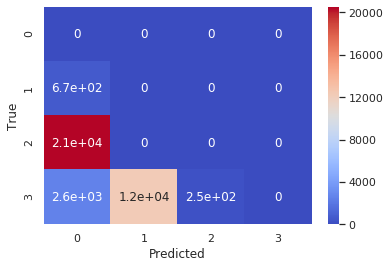

time: 285 ms


In [96]:
sns.heatmap(cmpp3hyp1_02,annot=True,cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('True')

## Change to correct labels

In [97]:
sc1pp3labelshyp1_02
sc1pp3labelshyp1_02[sc1pp3labelshyp1_02 == 0] = 4
sc1pp3labelshyp1_02[sc1pp3labelshyp1_02 == 1] = 5
sc1pp3labelshyp1_02[sc1pp3labelshyp1_02 == 2] = 6

time: 10.9 ms


In [98]:
sc1pp3labelshyp1_02[sc1pp3labelshyp1_02 == 4] = 2
sc1pp3labelshyp1_02[sc1pp3labelshyp1_02 == 5] = 1
sc1pp3labelshyp1_02[sc1pp3labelshyp1_02 == 6] = 3

time: 13.2 ms


## Check heatmap

In [99]:
cmpp3hyp1_02 = confusion_matrix(target_system.System, sc1pp3labelshyp1_02)

time: 41.4 ms


In [100]:
cmpp3hyp1_02

array([[    0,   671,     0],
       [    0, 20527,     0],
       [12288,  2615,   250]])

time: 4.05 ms


Text(30.5, 0.5, 'True')

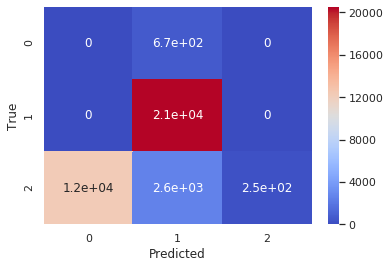

time: 261 ms


In [101]:
sns.heatmap(cmpp3hyp1_02,annot=True,cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('True')

In [102]:
reportpp3hyp1_02 = classification_report(target_system, sc1pp3labelshyp1_02,output_dict = True)

time: 42.9 ms


In [103]:
reportpp3hyp1_02

{'1': {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0, 'support': 671},
 '2': {'f1-score': 0.9258908434821831,
  'precision': 0.8620081468105657,
  'recall': 1.0,
  'support': 20527},
 '3': {'f1-score': 0.032461208855417784,
  'precision': 1.0,
  'recall': 0.016498383158450473,
  'support': 15153},
 'accuracy': 0.5715661192264312,
 'macro avg': {'f1-score': 0.31945068411253363,
  'precision': 0.6206693822701886,
  'recall': 0.33883279438615016,
  'support': 36351},
 'weighted avg': {'f1-score': 0.5363716553037032,
  'precision': 0.9036186412913119,
  'recall': 0.5715661192264312,
  'support': 36351}}

time: 4.4 ms


In [104]:
print("Confusion matrix\n",metrics.confusion_matrix(y_true=target_system.System,y_pred=sc1pp3labelshyp1_02)) 
print("Classification report\n",metrics.classification_report(y_true=target_system.System,y_pred=sc1pp3labelshyp1_02))

Confusion matrix
 [[    0   671     0]
 [    0 20527     0]
 [12288  2615   250]]
Classification report
               precision    recall  f1-score   support

           1       0.00      0.00      0.00       671
           2       0.86      1.00      0.93     20527
           3       1.00      0.02      0.03     15153

    accuracy                           0.57     36351
   macro avg       0.62      0.34      0.32     36351
weighted avg       0.90      0.57      0.54     36351

time: 81.4 ms


In [105]:
print('\033[1m'+"Kmeans++:"+'\033[0m')
print('\033[1m'+"System 1"+'\033[0m')
print("Precision = {0:0.3f}".format(reportpp3hyp1_02["1"]["precision"]))
print("Recall = {0:0.3f}".format(reportpp3hyp1_02["1"]["recall"]))
print("F1-score = {0:0.3f}".format(reportpp3hyp1_02["1"]["f1-score"]))
print("Support = {0:0.3f}".format(reportpp3hyp1_02["1"]["support"]))
print('\033[1m'+"System 2"+'\033[0m')
print("Precision = {0:0.3f}".format(reportpp3hyp1_02["2"]["precision"]))
print("Recall = {0:0.3f}".format(reportpp3hyp1_02["2"]["recall"]))
print("F1-score = {0:0.3f}".format(reportpp3hyp1_02["2"]["f1-score"]))
print("Support = {0:0.3f}".format(reportpp3hyp1_02["2"]["support"]))
print('\033[1m'+"System 3"+'\033[0m')
print("Precision = {0:0.3f}".format(reportpp3hyp1_02["3"]["precision"]))
print("Recall = {0:0.3f}".format(reportpp3hyp1_02["3"]["recall"]))
print("F1-score = {0:0.3f}".format(reportpp3hyp1_02["3"]["f1-score"]))
print("Support = {0:0.3f}".format(reportpp3hyp1_02["3"]["support"]))

Kmeans++:
System 1
Precision = 0.000
Recall = 0.000
F1-score = 0.000
Support = 671.000
System 2
Precision = 0.862
Recall = 1.000
F1-score = 0.926
Support = 20527.000
System 3
Precision = 1.000
Recall = 0.016
F1-score = 0.032
Support = 15153.000
time: 14.8 ms


In [106]:
print('\033[1m'+'Clustering metrics - supervised'+'\033[0m')
print('Adjusted Rand score: ', metrics.adjusted_rand_score(target_system.System, sc1pp3labelshyp1_02))
print('Mutual info score: ', metrics.adjusted_mutual_info_score(target_system.System, sc1pp3labelshyp1_02))
print('Homogeneity score: ', metrics.homogeneity_score(target_system.System, sc1pp3labelshyp1_02))
print('Completeness score: ', metrics.completeness_score(target_system.System, sc1pp3labelshyp1_02))
print('V-measure: ', metrics.v_measure_score(target_system.System, sc1pp3labelshyp1_02))
print('Fowlkes-Mallows score: ', metrics.fowlkes_mallows_score(target_system.System, sc1pp3labelshyp1_02))

Clustering metrics - supervised
Adjusted Rand score:  0.6823361077431518
Mutual info score:  0.6288415438002334
Homogeneity score:  0.5945082951466246
Completeness score:  0.6674481883802668
V-measure:  0.6288703132831915
Fowlkes-Mallows score:  0.8475658942266868
time: 72.8 ms


In [107]:
print('\033[1m'+'Clustering metrics - unsupervised'+'\033[0m')
print('Silhouette: ',metrics.silhouette_score(dfsc1, sc1pp3labelshyp1_02, metric='euclidean'))
print('Davies-Bouldin Index: ',metrics.davies_bouldin_score(dfsc1, sc1pp3labelshyp1_02))
print('Calinski-Harabasz Index: ',metrics.calinski_harabaz_score(dfsc1, sc1pp3labelshyp1_02))

Clustering metrics - unsupervised
Silhouette:  0.7988472575098736
Davies-Bouldin Index:  0.2191686775955013
Calinski-Harabasz Index:  226688.89004129928
time: 16.7 s


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=FutureWarning)


### 03 - n_init = 500

In [108]:
kmeansc1pp3hyp1_03 = KMeans(n_clusters=3, random_state=42, n_init=500).fit(dfsc1)

time: 7.59 s


In [109]:
kmeansc1pp3hyp1_03.labels_

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

time: 6.98 ms


In [110]:
sc1pp3labelshyp1_03 = pd.Series(kmeansc1pp3hyp1_03.labels_)

time: 1.46 ms


In [111]:
sc1pp3labelshyp1_03.value_counts()

0    23813
1    12288
2      250
dtype: int64

time: 15 ms


In [112]:
cmpp3hyp1_03 = confusion_matrix(target_system.System, sc1pp3labelshyp1_03)

time: 49.1 ms


In [113]:
cmpp3hyp1_03

array([[    0,     0,     0,     0],
       [  671,     0,     0,     0],
       [20527,     0,     0,     0],
       [ 2615, 12288,   250,     0]])

time: 3.81 ms


## Check correct labels

Text(30.5, 0.5, 'True')

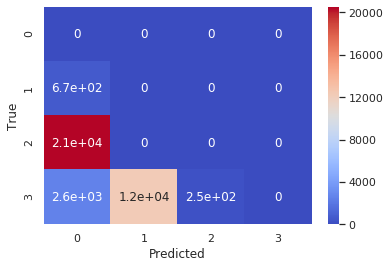

time: 271 ms


In [114]:
sns.heatmap(cmpp3hyp1_03,annot=True,cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('True')

## Change to correct labels

In [115]:
sc1pp3labelshyp1_03
sc1pp3labelshyp1_03[sc1pp3labelshyp1_03 == 0] = 4
sc1pp3labelshyp1_03[sc1pp3labelshyp1_03 == 1] = 5
sc1pp3labelshyp1_03[sc1pp3labelshyp1_03 == 2] = 6

time: 13.2 ms


In [116]:
sc1pp3labelshyp1_03[sc1pp3labelshyp1_03 == 4] = 2
sc1pp3labelshyp1_03[sc1pp3labelshyp1_03 == 5] = 1
sc1pp3labelshyp1_03[sc1pp3labelshyp1_03 == 6] = 3

time: 12.6 ms


## Check heatmap

In [117]:
cmpp3hyp1_03 = confusion_matrix(target_system.System, sc1pp3labelshyp1_03)

time: 44.2 ms


In [118]:
cmpp3hyp1_03

array([[    0,   671,     0],
       [    0, 20527,     0],
       [12288,  2615,   250]])

time: 2.85 ms


Text(30.5, 0.5, 'True')

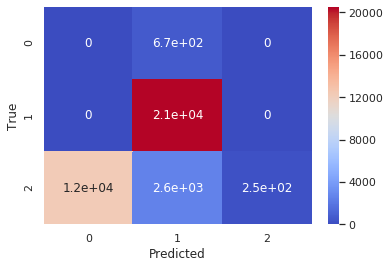

time: 252 ms


In [119]:
sns.heatmap(cmpp3hyp1_03,annot=True,cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('True')

In [120]:
reportpp3hyp1_03 = classification_report(target_system, sc1pp3labelshyp1_03,output_dict = True)

time: 49.6 ms


In [121]:
reportpp3hyp1_03

{'1': {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0, 'support': 671},
 '2': {'f1-score': 0.9258908434821831,
  'precision': 0.8620081468105657,
  'recall': 1.0,
  'support': 20527},
 '3': {'f1-score': 0.032461208855417784,
  'precision': 1.0,
  'recall': 0.016498383158450473,
  'support': 15153},
 'accuracy': 0.5715661192264312,
 'macro avg': {'f1-score': 0.31945068411253363,
  'precision': 0.6206693822701886,
  'recall': 0.33883279438615016,
  'support': 36351},
 'weighted avg': {'f1-score': 0.5363716553037032,
  'precision': 0.9036186412913119,
  'recall': 0.5715661192264312,
  'support': 36351}}

time: 3.59 ms


In [122]:
print("Confusion matrix\n",metrics.confusion_matrix(y_true=target_system.System,y_pred=sc1pp3labelshyp1_03)) 
print("Classification report\n",metrics.classification_report(y_true=target_system.System,y_pred=sc1pp3labelshyp1_03)) 

Confusion matrix
 [[    0   671     0]
 [    0 20527     0]
 [12288  2615   250]]
Classification report
               precision    recall  f1-score   support

           1       0.00      0.00      0.00       671
           2       0.86      1.00      0.93     20527
           3       1.00      0.02      0.03     15153

    accuracy                           0.57     36351
   macro avg       0.62      0.34      0.32     36351
weighted avg       0.90      0.57      0.54     36351

time: 85.3 ms


In [123]:
print('\033[1m'+"Kmeans++:"+'\033[0m')
print('\033[1m'+"System 1"+'\033[0m')
print("Precision = {0:0.3f}".format(reportpp3hyp1_03["1"]["precision"]))
print("Recall = {0:0.3f}".format(reportpp3hyp1_03["1"]["recall"]))
print("F1-score = {0:0.3f}".format(reportpp3hyp1_03["1"]["f1-score"]))
print("Support = {0:0.3f}".format(reportpp3hyp1_03["1"]["support"]))
print('\033[1m'+"System 2"+'\033[0m')
print("Precision = {0:0.3f}".format(reportpp3hyp1_03["2"]["precision"]))
print("Recall = {0:0.3f}".format(reportpp3hyp1_03["2"]["recall"]))
print("F1-score = {0:0.3f}".format(reportpp3hyp1_03["2"]["f1-score"]))
print("Support = {0:0.3f}".format(reportpp3hyp1_03["2"]["support"]))
print('\033[1m'+"System 3"+'\033[0m')
print("Precision = {0:0.3f}".format(reportpp3hyp1_03["3"]["precision"]))
print("Recall = {0:0.3f}".format(reportpp3hyp1_03["3"]["recall"]))
print("F1-score = {0:0.3f}".format(reportpp3hyp1_03["3"]["f1-score"]))
print("Support = {0:0.3f}".format(reportpp3hyp1_03["3"]["support"]))

Kmeans++:
System 1
Precision = 0.000
Recall = 0.000
F1-score = 0.000
Support = 671.000
System 2
Precision = 0.862
Recall = 1.000
F1-score = 0.926
Support = 20527.000
System 3
Precision = 1.000
Recall = 0.016
F1-score = 0.032
Support = 15153.000
time: 18.9 ms


In [124]:
print('\033[1m'+'Clustering metrics - supervised'+'\033[0m')
print('Adjusted Rand score: ', metrics.adjusted_rand_score(target_system.System, sc1pp3labelshyp1_03))
print('Mutual info score: ', metrics.adjusted_mutual_info_score(target_system.System, sc1pp3labelshyp1_03))
print('Homogeneity score: ', metrics.homogeneity_score(target_system.System, sc1pp3labelshyp1_03))
print('Completeness score: ', metrics.completeness_score(target_system.System, sc1pp3labelshyp1_03))
print('V-measure: ', metrics.v_measure_score(target_system.System, sc1pp3labelshyp1_03))
print('Fowlkes-Mallows score: ', metrics.fowlkes_mallows_score(target_system.System, sc1pp3labelshyp1_03))

Clustering metrics - supervised
Adjusted Rand score:  0.6823361077431518
Mutual info score:  0.6288415438002334
Homogeneity score:  0.5945082951466246
Completeness score:  0.6674481883802668
V-measure:  0.6288703132831915
Fowlkes-Mallows score:  0.8475658942266868
time: 70.7 ms


In [125]:
print('\033[1m'+'Clustering metrics - unsupervised'+'\033[0m')
print('Silhouette: ',metrics.silhouette_score(dfsc1, sc1pp3labelshyp1_03, metric='euclidean'))
print('Davies-Bouldin Index: ',metrics.davies_bouldin_score(dfsc1, sc1pp3labelshyp1_03))
print('Calinski-Harabasz Index: ',metrics.calinski_harabaz_score(dfsc1, sc1pp3labelshyp1_03))

Clustering metrics - unsupervised
Silhouette:  0.7988472575098736
Davies-Bouldin Index:  0.2191686775955013
Calinski-Harabasz Index:  226688.89004129928
time: 16.7 s


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=FutureWarning)


## Hyperparameter analysis: max_iter

### 3 scenarios: 100, 300 and 500

### 01 - max_iter = 100

In [126]:
kmeansc1pp3hyp2_01 = KMeans(n_clusters=3, random_state=42, max_iter=100).fit(dfsc1)

time: 160 ms


In [127]:
kmeansc1pp3hyp2_01.labels_

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

time: 6.07 ms


In [128]:
sc1pp3labelshyp2_01 = pd.Series(kmeansc1pp3hyp2_01.labels_)

time: 1.5 ms


In [129]:
sc1pp3labelshyp2_01.value_counts()

0    23813
1    12288
2      250
dtype: int64

time: 15.8 ms


In [130]:
cmpp3hyp2_01 = confusion_matrix(target_system.System, sc1pp3labelshyp2_01)

time: 52.9 ms


In [131]:
cmpp3hyp2_01

array([[    0,     0,     0,     0],
       [  671,     0,     0,     0],
       [20527,     0,     0,     0],
       [ 2615, 12288,   250,     0]])

time: 3.94 ms


## Check correct labels

Text(30.5, 0.5, 'True')

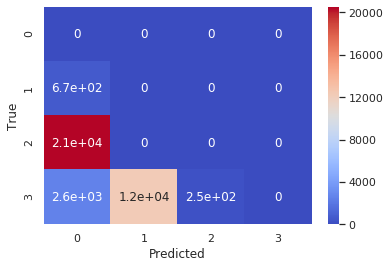

time: 380 ms


In [132]:
sns.heatmap(cmpp3hyp2_01,annot=True,cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('True')

## Change to correct labels

In [133]:
sc1pp3labelshyp2_01
sc1pp3labelshyp2_01[sc1pp3labelshyp2_01 == 0] = 4
sc1pp3labelshyp2_01[sc1pp3labelshyp2_01 == 1] = 5
sc1pp3labelshyp2_01[sc1pp3labelshyp2_01 == 2] = 6

time: 14.2 ms


In [134]:
sc1pp3labelshyp2_01[sc1pp3labelshyp2_01 == 4] = 2
sc1pp3labelshyp2_01[sc1pp3labelshyp2_01 == 5] = 1
sc1pp3labelshyp2_01[sc1pp3labelshyp2_01 == 6] = 3

time: 14.2 ms


## Check heatmap

In [135]:
cmpp3hyp2_01 = confusion_matrix(target_system.System, sc1pp3labelshyp2_01)

time: 37.9 ms


In [136]:
cmpp3hyp2_01

array([[    0,   671,     0],
       [    0, 20527,     0],
       [12288,  2615,   250]])

time: 3.79 ms


Text(30.5, 0.5, 'True')

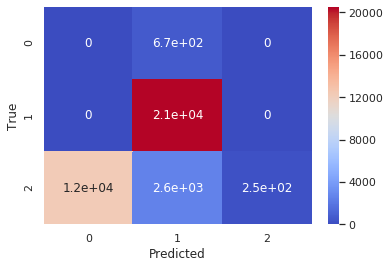

time: 250 ms


In [137]:
sns.heatmap(cmpp3hyp2_01,annot=True,cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('True')

In [138]:
reportpp3hyp2_01 = classification_report(target_system, sc1pp3labelshyp2_01,output_dict = True)

time: 42.3 ms


In [139]:
reportpp3hyp2_01

{'1': {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0, 'support': 671},
 '2': {'f1-score': 0.9258908434821831,
  'precision': 0.8620081468105657,
  'recall': 1.0,
  'support': 20527},
 '3': {'f1-score': 0.032461208855417784,
  'precision': 1.0,
  'recall': 0.016498383158450473,
  'support': 15153},
 'accuracy': 0.5715661192264312,
 'macro avg': {'f1-score': 0.31945068411253363,
  'precision': 0.6206693822701886,
  'recall': 0.33883279438615016,
  'support': 36351},
 'weighted avg': {'f1-score': 0.5363716553037032,
  'precision': 0.9036186412913119,
  'recall': 0.5715661192264312,
  'support': 36351}}

time: 3.12 ms


In [140]:
print("Confusion matrix\n",metrics.confusion_matrix(y_true=target_system.System,y_pred=sc1pp3labelshyp2_01)) 
print("Classification report\n",metrics.classification_report(y_true=target_system.System,y_pred=sc1pp3labelshyp2_01))

Confusion matrix
 [[    0   671     0]
 [    0 20527     0]
 [12288  2615   250]]
Classification report
               precision    recall  f1-score   support

           1       0.00      0.00      0.00       671
           2       0.86      1.00      0.93     20527
           3       1.00      0.02      0.03     15153

    accuracy                           0.57     36351
   macro avg       0.62      0.34      0.32     36351
weighted avg       0.90      0.57      0.54     36351

time: 83.5 ms


In [141]:
print('\033[1m'+"Kmeans++:"+'\033[0m')
print('\033[1m'+"System 1"+'\033[0m')
print("Precision = {0:0.3f}".format(reportpp3hyp2_01["1"]["precision"]))
print("Recall = {0:0.3f}".format(reportpp3hyp2_01["1"]["recall"]))
print("F1-score = {0:0.3f}".format(reportpp3hyp2_01["1"]["f1-score"]))
print("Support = {0:0.3f}".format(reportpp3hyp2_01["1"]["support"]))
print('\033[1m'+"System 2"+'\033[0m')
print("Precision = {0:0.3f}".format(reportpp3hyp2_01["2"]["precision"]))
print("Recall = {0:0.3f}".format(reportpp3hyp2_01["2"]["recall"]))
print("F1-score = {0:0.3f}".format(reportpp3hyp2_01["2"]["f1-score"]))
print("Support = {0:0.3f}".format(reportpp3hyp2_01["2"]["support"]))
print('\033[1m'+"System 3"+'\033[0m')
print("Precision = {0:0.3f}".format(reportpp3hyp2_01["3"]["precision"]))
print("Recall = {0:0.3f}".format(reportpp3hyp2_01["3"]["recall"]))
print("F1-score = {0:0.3f}".format(reportpp3hyp2_01["3"]["f1-score"]))
print("Support = {0:0.3f}".format(reportpp3hyp2_01["3"]["support"]))

Kmeans++:
System 1
Precision = 0.000
Recall = 0.000
F1-score = 0.000
Support = 671.000
System 2
Precision = 0.862
Recall = 1.000
F1-score = 0.926
Support = 20527.000
System 3
Precision = 1.000
Recall = 0.016
F1-score = 0.032
Support = 15153.000
time: 11.4 ms


In [142]:
print('\033[1m'+'Clustering metrics - supervised'+'\033[0m')
print('Adjusted Rand score: ', metrics.adjusted_rand_score(target_system.System, sc1pp3labelshyp2_01))
print('Mutual info score: ', metrics.adjusted_mutual_info_score(target_system.System, sc1pp3labelshyp2_01))
print('Homogeneity score: ', metrics.homogeneity_score(target_system.System, sc1pp3labelshyp2_01))
print('Completeness score: ', metrics.completeness_score(target_system.System, sc1pp3labelshyp2_01))
print('V-measure: ', metrics.v_measure_score(target_system.System, sc1pp3labelshyp2_01))
print('Fowlkes-Mallows score: ', metrics.fowlkes_mallows_score(target_system.System, sc1pp3labelshyp2_01))

Clustering metrics - supervised
Adjusted Rand score:  0.6823361077431518
Mutual info score:  0.6288415438002334
Homogeneity score:  0.5945082951466246
Completeness score:  0.6674481883802668
V-measure:  0.6288703132831915
Fowlkes-Mallows score:  0.8475658942266868
time: 76.3 ms


In [143]:
print('\033[1m'+'Clustering metrics - unsupervised'+'\033[0m')
print('Silhouette: ',metrics.silhouette_score(dfsc1, sc1pp3labelshyp2_01, metric='euclidean'))
print('Davies-Bouldin Index: ',metrics.davies_bouldin_score(dfsc1, sc1pp3labelshyp2_01))
print('Calinski-Harabasz Index: ',metrics.calinski_harabaz_score(dfsc1, sc1pp3labelshyp2_01))

Clustering metrics - unsupervised
Silhouette:  0.7988472575098736
Davies-Bouldin Index:  0.2191686775955013
Calinski-Harabasz Index:  226688.89004129928
time: 16.8 s


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=FutureWarning)


### 02 - max_iter = 500

In [144]:
kmeansc1pp3hyp2_02 = KMeans(n_clusters=3, random_state=42, max_iter=500).fit(dfsc1)

time: 162 ms


In [145]:
kmeansc1pp3hyp2_02.labels_

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

time: 3.61 ms


In [146]:
sc1pp3labelshyp2_02 = pd.Series(kmeansc1pp3hyp2_02.labels_)

time: 3.01 ms


In [147]:
sc1pp3labelshyp2_02.value_counts()

0    23813
1    12288
2      250
dtype: int64

time: 16.6 ms


In [148]:
cmpp3hyp2_02 = confusion_matrix(target_system.System, sc1pp3labelshyp2_02)

time: 58 ms


In [149]:
cmpp3hyp2_02

array([[    0,     0,     0,     0],
       [  671,     0,     0,     0],
       [20527,     0,     0,     0],
       [ 2615, 12288,   250,     0]])

time: 3.55 ms


## Check correct labels

Text(30.5, 0.5, 'True')

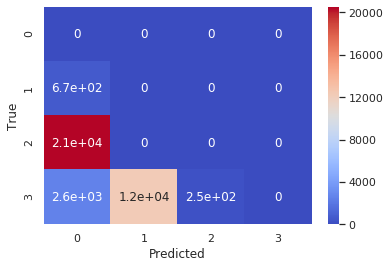

time: 267 ms


In [150]:
sns.heatmap(cmpp3hyp2_02,annot=True,cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('True')

## Change to correct labels

In [151]:
sc1pp3labelshyp2_02
sc1pp3labelshyp2_02[sc1pp3labelshyp2_02 == 0] = 4
sc1pp3labelshyp2_02[sc1pp3labelshyp2_02 == 1] = 5
sc1pp3labelshyp2_02[sc1pp3labelshyp2_02 == 2] = 6

time: 14.8 ms


In [152]:
sc1pp3labelshyp2_02[sc1pp3labelshyp2_02 == 4] = 2
sc1pp3labelshyp2_02[sc1pp3labelshyp2_02 == 5] = 1
sc1pp3labelshyp2_02[sc1pp3labelshyp2_02 == 6] = 3

time: 13.2 ms


## Check heatmap

In [153]:
cmpp3hyp2_02 = confusion_matrix(target_system.System, sc1pp3labelshyp2_02)

time: 46.9 ms


In [154]:
cmpp3hyp2_02

array([[    0,   671,     0],
       [    0, 20527,     0],
       [12288,  2615,   250]])

time: 3.55 ms


Text(30.5, 0.5, 'True')

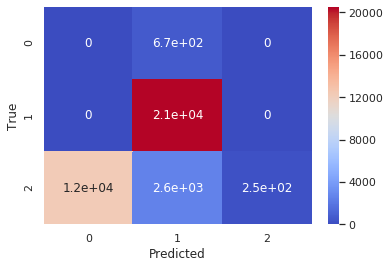

time: 247 ms


In [155]:
sns.heatmap(cmpp3hyp2_02,annot=True,cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('True')

In [156]:
reportpp3hyp2_02 = classification_report(target_system, sc1pp3labelshyp2_02,output_dict = True)

time: 44.8 ms


In [157]:
reportpp3hyp2_02

{'1': {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0, 'support': 671},
 '2': {'f1-score': 0.9258908434821831,
  'precision': 0.8620081468105657,
  'recall': 1.0,
  'support': 20527},
 '3': {'f1-score': 0.032461208855417784,
  'precision': 1.0,
  'recall': 0.016498383158450473,
  'support': 15153},
 'accuracy': 0.5715661192264312,
 'macro avg': {'f1-score': 0.31945068411253363,
  'precision': 0.6206693822701886,
  'recall': 0.33883279438615016,
  'support': 36351},
 'weighted avg': {'f1-score': 0.5363716553037032,
  'precision': 0.9036186412913119,
  'recall': 0.5715661192264312,
  'support': 36351}}

time: 4.19 ms


In [158]:
print("Confusion matrix\n",metrics.confusion_matrix(y_true=target_system.System,y_pred=sc1pp3labelshyp2_02)) 
print("Classification report\n",metrics.classification_report(y_true=target_system.System,y_pred=sc1pp3labelshyp2_02)) 

Confusion matrix
 [[    0   671     0]
 [    0 20527     0]
 [12288  2615   250]]
Classification report
               precision    recall  f1-score   support

           1       0.00      0.00      0.00       671
           2       0.86      1.00      0.93     20527
           3       1.00      0.02      0.03     15153

    accuracy                           0.57     36351
   macro avg       0.62      0.34      0.32     36351
weighted avg       0.90      0.57      0.54     36351

time: 79.8 ms


In [159]:
print('\033[1m'+"Kmeans++:"+'\033[0m')
print('\033[1m'+"System 1"+'\033[0m')
print("Precision = {0:0.3f}".format(reportpp3hyp2_02["1"]["precision"]))
print("Recall = {0:0.3f}".format(reportpp3hyp2_02["1"]["recall"]))
print("F1-score = {0:0.3f}".format(reportpp3hyp2_02["1"]["f1-score"]))
print("Support = {0:0.3f}".format(reportpp3hyp2_02["1"]["support"]))
print('\033[1m'+"System 2"+'\033[0m')
print("Precision = {0:0.3f}".format(reportpp3hyp2_02["2"]["precision"]))
print("Recall = {0:0.3f}".format(reportpp3hyp2_02["2"]["recall"]))
print("F1-score = {0:0.3f}".format(reportpp3hyp2_02["2"]["f1-score"]))
print("Support = {0:0.3f}".format(reportpp3hyp2_02["2"]["support"]))
print('\033[1m'+"System 3"+'\033[0m')
print("Precision = {0:0.3f}".format(reportpp3hyp2_02["3"]["precision"]))
print("Recall = {0:0.3f}".format(reportpp3hyp2_02["3"]["recall"]))
print("F1-score = {0:0.3f}".format(reportpp3hyp2_02["3"]["f1-score"]))
print("Support = {0:0.3f}".format(reportpp3hyp2_02["3"]["support"]))

Kmeans++:
System 1
Precision = 0.000
Recall = 0.000
F1-score = 0.000
Support = 671.000
System 2
Precision = 0.862
Recall = 1.000
F1-score = 0.926
Support = 20527.000
System 3
Precision = 1.000
Recall = 0.016
F1-score = 0.032
Support = 15153.000
time: 17.3 ms


In [160]:
print('\033[1m'+'Clustering metrics - supervised'+'\033[0m')
print('Adjusted Rand score: ', metrics.adjusted_rand_score(target_system.System, sc1pp3labelshyp2_02))
print('Mutual info score: ', metrics.adjusted_mutual_info_score(target_system.System, sc1pp3labelshyp2_02))
print('Homogeneity score: ', metrics.homogeneity_score(target_system.System, sc1pp3labelshyp2_02))
print('Completeness score: ', metrics.completeness_score(target_system.System, sc1pp3labelshyp2_02))
print('V-measure: ', metrics.v_measure_score(target_system.System, sc1pp3labelshyp2_02))
print('Fowlkes-Mallows score: ', metrics.fowlkes_mallows_score(target_system.System, sc1pp3labelshyp2_02))

Clustering metrics - supervised
Adjusted Rand score:  0.6823361077431518
Mutual info score:  0.6288415438002334
Homogeneity score:  0.5945082951466246
Completeness score:  0.6674481883802668
V-measure:  0.6288703132831915
Fowlkes-Mallows score:  0.8475658942266868
time: 70.3 ms


In [161]:
print('\033[1m'+'Clustering metrics - unsupervised'+'\033[0m')
print('Silhouette: ',metrics.silhouette_score(dfsc1, sc1pp3labelshyp2_02, metric='euclidean'))
print('Davies-Bouldin Index: ',metrics.davies_bouldin_score(dfsc1, sc1pp3labelshyp2_02))
print('Calinski-Harabasz Index: ',metrics.calinski_harabaz_score(dfsc1, sc1pp3labelshyp2_02))

Clustering metrics - unsupervised
Silhouette:  0.7988472575098736
Davies-Bouldin Index:  0.2191686775955013
Calinski-Harabasz Index:  226688.89004129928
time: 16.7 s


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=FutureWarning)


### 03 - max_iter = 1000

In [162]:
kmeansc1pp3hyp2_03 = KMeans(n_clusters=3, random_state=42, max_iter=1000).fit(dfsc1)

time: 172 ms


In [163]:
kmeansc1pp3hyp2_03.labels_

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

time: 12.2 ms


In [164]:
sc1pp3labelshyp2_03 = pd.Series(kmeansc1pp3hyp2_03.labels_)

time: 3.14 ms


In [165]:
sc1pp3labelshyp2_03.value_counts()

0    23813
1    12288
2      250
dtype: int64

time: 19 ms


In [166]:
cmpp3hyp2_03 = confusion_matrix(target_system.System, sc1pp3labelshyp2_03)

time: 41.3 ms


In [167]:
cmpp3hyp2_03

array([[    0,     0,     0,     0],
       [  671,     0,     0,     0],
       [20527,     0,     0,     0],
       [ 2615, 12288,   250,     0]])

time: 3.55 ms


## Check correct labels

Text(30.5, 0.5, 'True')

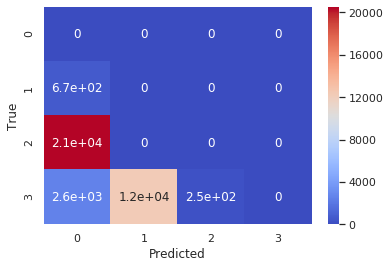

time: 282 ms


In [168]:
sns.heatmap(cmpp3hyp2_03,annot=True,cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('True')

## Change to correct labels

In [169]:
sc1pp3labelshyp2_03
sc1pp3labelshyp2_03[sc1pp3labelshyp2_03 == 0] = 4
sc1pp3labelshyp2_03[sc1pp3labelshyp2_03 == 1] = 5
sc1pp3labelshyp2_03[sc1pp3labelshyp2_03 == 2] = 6

time: 12.5 ms


In [170]:
sc1pp3labelshyp2_03[sc1pp3labelshyp2_03 == 4] = 2
sc1pp3labelshyp2_03[sc1pp3labelshyp2_03 == 5] = 1
sc1pp3labelshyp2_03[sc1pp3labelshyp2_03 == 6] = 3

time: 13.3 ms


## Check heatmap

In [171]:
cmpp3hyp2_03 = confusion_matrix(target_system.System, sc1pp3labelshyp2_03)

time: 36.9 ms


In [172]:
cmpp3hyp2_03

array([[    0,   671,     0],
       [    0, 20527,     0],
       [12288,  2615,   250]])

time: 3.37 ms


Text(30.5, 0.5, 'True')

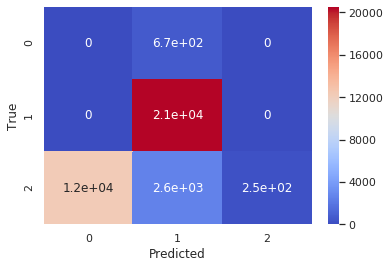

time: 257 ms


In [173]:
sns.heatmap(cmpp3hyp2_03,annot=True,cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('True')

In [174]:
reportpp3hyp2_03 = classification_report(target_system, sc1pp3labelshyp2_03,output_dict = True)

time: 44.4 ms


In [175]:
reportpp3hyp2_03

{'1': {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0, 'support': 671},
 '2': {'f1-score': 0.9258908434821831,
  'precision': 0.8620081468105657,
  'recall': 1.0,
  'support': 20527},
 '3': {'f1-score': 0.032461208855417784,
  'precision': 1.0,
  'recall': 0.016498383158450473,
  'support': 15153},
 'accuracy': 0.5715661192264312,
 'macro avg': {'f1-score': 0.31945068411253363,
  'precision': 0.6206693822701886,
  'recall': 0.33883279438615016,
  'support': 36351},
 'weighted avg': {'f1-score': 0.5363716553037032,
  'precision': 0.9036186412913119,
  'recall': 0.5715661192264312,
  'support': 36351}}

time: 4.14 ms


In [176]:
print("Confusion matrix\n",metrics.confusion_matrix(y_true=target_system.System,y_pred=sc1pp3labelshyp2_03)) 
print("Classification report\n",metrics.classification_report(y_true=target_system.System,y_pred=sc1pp3labelshyp2_03))

Confusion matrix
 [[    0   671     0]
 [    0 20527     0]
 [12288  2615   250]]
Classification report
               precision    recall  f1-score   support

           1       0.00      0.00      0.00       671
           2       0.86      1.00      0.93     20527
           3       1.00      0.02      0.03     15153

    accuracy                           0.57     36351
   macro avg       0.62      0.34      0.32     36351
weighted avg       0.90      0.57      0.54     36351

time: 79.4 ms


In [177]:
print('\033[1m'+"Kmeans++:"+'\033[0m')
print('\033[1m'+"System 1"+'\033[0m')
print("Precision = {0:0.3f}".format(reportpp3hyp2_03["1"]["precision"]))
print("Recall = {0:0.3f}".format(reportpp3hyp2_03["1"]["recall"]))
print("F1-score = {0:0.3f}".format(reportpp3hyp2_03["1"]["f1-score"]))
print("Support = {0:0.3f}".format(reportpp3hyp2_03["1"]["support"]))
print('\033[1m'+"System 2"+'\033[0m')
print("Precision = {0:0.3f}".format(reportpp3hyp2_03["2"]["precision"]))
print("Recall = {0:0.3f}".format(reportpp3hyp2_03["2"]["recall"]))
print("F1-score = {0:0.3f}".format(reportpp3hyp2_03["2"]["f1-score"]))
print("Support = {0:0.3f}".format(reportpp3hyp2_03["2"]["support"]))
print('\033[1m'+"System 3"+'\033[0m')
print("Precision = {0:0.3f}".format(reportpp3hyp2_03["3"]["precision"]))
print("Recall = {0:0.3f}".format(reportpp3hyp2_03["3"]["recall"]))
print("F1-score = {0:0.3f}".format(reportpp3hyp2_03["3"]["f1-score"]))
print("Support = {0:0.3f}".format(reportpp3hyp2_03["3"]["support"]))

Kmeans++:
System 1
Precision = 0.000
Recall = 0.000
F1-score = 0.000
Support = 671.000
System 2
Precision = 0.862
Recall = 1.000
F1-score = 0.926
Support = 20527.000
System 3
Precision = 1.000
Recall = 0.016
F1-score = 0.032
Support = 15153.000
time: 15.2 ms


In [178]:
print('\033[1m'+'Clustering metrics - supervised'+'\033[0m')
print('Adjusted Rand score: ', metrics.adjusted_rand_score(target_system.System, sc1pp3labelshyp2_03))
print('Mutual info score: ', metrics.adjusted_mutual_info_score(target_system.System, sc1pp3labelshyp2_03))
print('Homogeneity score: ', metrics.homogeneity_score(target_system.System, sc1pp3labelshyp2_03))
print('Completeness score: ', metrics.completeness_score(target_system.System, sc1pp3labelshyp2_03))
print('V-measure: ', metrics.v_measure_score(target_system.System, sc1pp3labelshyp2_03))
print('Fowlkes-Mallows score: ', metrics.fowlkes_mallows_score(target_system.System, sc1pp3labelshyp2_03))

Clustering metrics - supervised
Adjusted Rand score:  0.6823361077431518
Mutual info score:  0.6288415438002334
Homogeneity score:  0.5945082951466246
Completeness score:  0.6674481883802668
V-measure:  0.6288703132831915
Fowlkes-Mallows score:  0.8475658942266868
time: 70.6 ms


In [179]:
print('\033[1m'+'Clustering metrics - unsupervised'+'\033[0m')
print('Silhouette: ',metrics.silhouette_score(dfsc1, sc1pp3labelshyp2_03, metric='euclidean'))
print('Davies-Bouldin Index: ',metrics.davies_bouldin_score(dfsc1, sc1pp3labelshyp2_03))
print('Calinski-Harabasz Index: ',metrics.calinski_harabaz_score(dfsc1, sc1pp3labelshyp2_03))

Clustering metrics - unsupervised
Silhouette:  0.7988472575098736
Davies-Bouldin Index:  0.2191686775955013
Calinski-Harabasz Index:  226688.89004129928
time: 16.7 s


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=FutureWarning)


## Hyperparameter analysis: tol

### 3 scenarios: 0.001, 0.01, 0.1

### 01 - tol = 0.001

In [180]:
kmeansc1pp3hyp3_01 = KMeans(n_clusters=3, random_state=42, tol=0.001).fit(dfsc1)

time: 166 ms


In [181]:
kmeansc1pp3hyp3_01.labels_

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

time: 3.26 ms


In [182]:
sc1pp3labelshyp3_01 = pd.Series(kmeansc1pp3hyp3_01.labels_)

time: 3.08 ms


In [183]:
sc1pp3labelshyp3_01.value_counts()

0    23813
1    12288
2      250
dtype: int64

time: 12.2 ms


In [184]:
cmpp3hyp3_01 = confusion_matrix(target_system.System, sc1pp3labelshyp3_01)

time: 63.4 ms


In [185]:
cmpp3hyp3_01

array([[    0,     0,     0,     0],
       [  671,     0,     0,     0],
       [20527,     0,     0,     0],
       [ 2615, 12288,   250,     0]])

time: 3.27 ms


## Check correct labels

Text(30.5, 0.5, 'True')

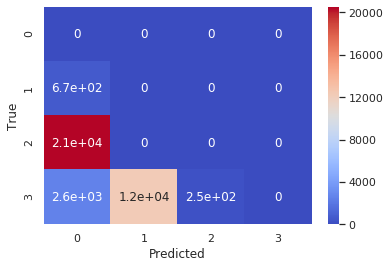

time: 287 ms


In [186]:
sns.heatmap(cmpp3hyp3_01,annot=True,cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('True')

## Change to correct labels

In [187]:
sc1pp3labelshyp3_01
sc1pp3labelshyp3_01[sc1pp3labelshyp3_01 == 0] = 4
sc1pp3labelshyp3_01[sc1pp3labelshyp3_01 == 1] = 5
sc1pp3labelshyp3_01[sc1pp3labelshyp3_01 == 2] = 6

time: 15.3 ms


In [188]:
sc1pp3labelshyp3_01[sc1pp3labelshyp3_01 == 4] = 2
sc1pp3labelshyp3_01[sc1pp3labelshyp3_01 == 5] = 1
sc1pp3labelshyp3_01[sc1pp3labelshyp3_01 == 6] = 3

time: 11.9 ms


## Check heatmap

In [189]:
cmpp3hyp3_01 = confusion_matrix(target_system.System, sc1pp3labelshyp3_01)

time: 40.9 ms


In [190]:
cmpp3hyp3_01

array([[    0,   671,     0],
       [    0, 20527,     0],
       [12288,  2615,   250]])

time: 3.94 ms


Text(30.5, 0.5, 'True')

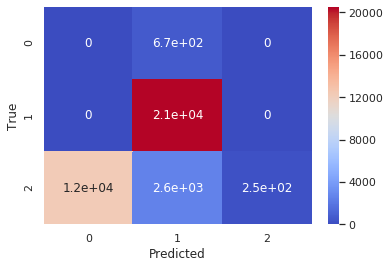

time: 254 ms


In [191]:
sns.heatmap(cmpp3hyp3_01,annot=True,cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('True')

In [192]:
reportpp3hyp3_01 = classification_report(target_system, sc1pp3labelshyp3_01,output_dict = True)

time: 44.9 ms


In [193]:
reportpp3hyp3_01

{'1': {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0, 'support': 671},
 '2': {'f1-score': 0.9258908434821831,
  'precision': 0.8620081468105657,
  'recall': 1.0,
  'support': 20527},
 '3': {'f1-score': 0.032461208855417784,
  'precision': 1.0,
  'recall': 0.016498383158450473,
  'support': 15153},
 'accuracy': 0.5715661192264312,
 'macro avg': {'f1-score': 0.31945068411253363,
  'precision': 0.6206693822701886,
  'recall': 0.33883279438615016,
  'support': 36351},
 'weighted avg': {'f1-score': 0.5363716553037032,
  'precision': 0.9036186412913119,
  'recall': 0.5715661192264312,
  'support': 36351}}

time: 3.39 ms


In [194]:
print("Confusion matrix\n",metrics.confusion_matrix(y_true=target_system.System,y_pred=sc1pp3labelshyp3_01)) 
print("Classification report\n",metrics.classification_report(y_true=target_system.System,y_pred=sc1pp3labelshyp3_01))

Confusion matrix
 [[    0   671     0]
 [    0 20527     0]
 [12288  2615   250]]
Classification report
               precision    recall  f1-score   support

           1       0.00      0.00      0.00       671
           2       0.86      1.00      0.93     20527
           3       1.00      0.02      0.03     15153

    accuracy                           0.57     36351
   macro avg       0.62      0.34      0.32     36351
weighted avg       0.90      0.57      0.54     36351

time: 82.2 ms


In [195]:
print('\033[1m'+"Kmeans++:"+'\033[0m')
print('\033[1m'+"System 1"+'\033[0m')
print("Precision = {0:0.3f}".format(reportpp3hyp3_01["1"]["precision"]))
print("Recall = {0:0.3f}".format(reportpp3hyp3_01["1"]["recall"]))
print("F1-score = {0:0.3f}".format(reportpp3hyp3_01["1"]["f1-score"]))
print("Support = {0:0.3f}".format(reportpp3hyp3_01["1"]["support"]))
print('\033[1m'+"System 2"+'\033[0m')
print("Precision = {0:0.3f}".format(reportpp3hyp3_01["2"]["precision"]))
print("Recall = {0:0.3f}".format(reportpp3hyp3_01["2"]["recall"]))
print("F1-score = {0:0.3f}".format(reportpp3hyp3_01["2"]["f1-score"]))
print("Support = {0:0.3f}".format(reportpp3hyp3_01["2"]["support"]))
print('\033[1m'+"System 3"+'\033[0m')
print("Precision = {0:0.3f}".format(reportpp3hyp3_01["3"]["precision"]))
print("Recall = {0:0.3f}".format(reportpp3hyp3_01["3"]["recall"]))
print("F1-score = {0:0.3f}".format(reportpp3hyp3_01["3"]["f1-score"]))
print("Support = {0:0.3f}".format(reportpp3hyp3_01["3"]["support"]))

Kmeans++:
System 1
Precision = 0.000
Recall = 0.000
F1-score = 0.000
Support = 671.000
System 2
Precision = 0.862
Recall = 1.000
F1-score = 0.926
Support = 20527.000
System 3
Precision = 1.000
Recall = 0.016
F1-score = 0.032
Support = 15153.000
time: 15.2 ms


In [196]:
print('\033[1m'+'Clustering metrics - supervised'+'\033[0m')
print('Adjusted Rand score: ', metrics.adjusted_rand_score(target_system.System, sc1pp3labelshyp3_01))
print('Mutual info score: ', metrics.adjusted_mutual_info_score(target_system.System, sc1pp3labelshyp3_01))
print('Homogeneity score: ', metrics.homogeneity_score(target_system.System, sc1pp3labelshyp3_01))
print('Completeness score: ', metrics.completeness_score(target_system.System, sc1pp3labelshyp3_01))
print('V-measure: ', metrics.v_measure_score(target_system.System, sc1pp3labelshyp3_01))
print('Fowlkes-Mallows score: ', metrics.fowlkes_mallows_score(target_system.System, sc1pp3labelshyp3_01))

Clustering metrics - supervised
Adjusted Rand score:  0.6823361077431518
Mutual info score:  0.6288415438002334
Homogeneity score:  0.5945082951466246
Completeness score:  0.6674481883802668
V-measure:  0.6288703132831915
Fowlkes-Mallows score:  0.8475658942266868
time: 71 ms


In [197]:
print('\033[1m'+'Clustering metrics - unsupervised'+'\033[0m')
print('Silhouette: ',metrics.silhouette_score(dfsc1, sc1pp3labelshyp3_01, metric='euclidean'))
print('Davies-Bouldin Index: ',metrics.davies_bouldin_score(dfsc1, sc1pp3labelshyp3_01))
print('Calinski-Harabasz Index: ',metrics.calinski_harabaz_score(dfsc1, sc1pp3labelshyp3_01))

Clustering metrics - unsupervised
Silhouette:  0.7988472575098736
Davies-Bouldin Index:  0.2191686775955013
Calinski-Harabasz Index:  226688.89004129928
time: 16.9 s


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=FutureWarning)


### 02 - tol = 0.01

In [198]:
kmeansc1pp3hyp3_02 = KMeans(n_clusters=3, random_state=42, tol=0.01).fit(dfsc1)

time: 160 ms


In [199]:
kmeansc1pp3hyp3_02.labels_

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

time: 3.9 ms


In [200]:
sc1pp3labelshyp3_02 = pd.Series(kmeansc1pp3hyp3_02.labels_)

time: 2.71 ms


In [201]:
sc1pp3labelshyp3_02.value_counts()

0    23813
1    12288
2      250
dtype: int64

time: 13.5 ms


In [202]:
cmpp3hyp3_02 = confusion_matrix(target_system.System, sc1pp3labelshyp3_02)

time: 55.1 ms


In [203]:
cmpp3hyp3_02

array([[    0,     0,     0,     0],
       [  671,     0,     0,     0],
       [20527,     0,     0,     0],
       [ 2615, 12288,   250,     0]])

time: 7.8 ms


## Check correct labels

Text(30.5, 0.5, 'True')

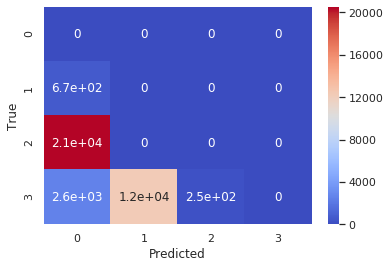

time: 265 ms


In [204]:
sns.heatmap(cmpp3hyp3_02,annot=True,cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('True')

## Change to correct labels

In [205]:
sc1pp3labelshyp3_02
sc1pp3labelshyp3_02[sc1pp3labelshyp3_02 == 0] = 4
sc1pp3labelshyp3_02[sc1pp3labelshyp3_02 == 1] = 5
sc1pp3labelshyp3_02[sc1pp3labelshyp3_02 == 2] = 6

time: 12.6 ms


In [206]:
sc1pp3labelshyp3_02[sc1pp3labelshyp3_02 == 4] = 2
sc1pp3labelshyp3_02[sc1pp3labelshyp3_02 == 5] = 1
sc1pp3labelshyp3_02[sc1pp3labelshyp3_02 == 6] = 3

time: 13.4 ms


## Check heatmap

In [207]:
cmpp3hyp3_02 = confusion_matrix(target_system.System, sc1pp3labelshyp3_02)

time: 36.6 ms


In [208]:
cmpp3hyp3_02

array([[    0,   671,     0],
       [    0, 20527,     0],
       [12288,  2615,   250]])

time: 3.37 ms


Text(30.5, 0.5, 'True')

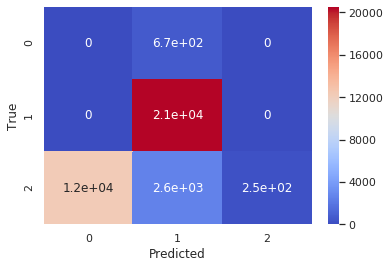

time: 243 ms


In [209]:
sns.heatmap(cmpp3hyp3_02,annot=True,cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('True')

In [210]:
reportpp3hyp3_02 = classification_report(target_system, sc1pp3labelshyp3_02,output_dict = True)

time: 45.4 ms


In [211]:
reportpp3hyp3_02

{'1': {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0, 'support': 671},
 '2': {'f1-score': 0.9258908434821831,
  'precision': 0.8620081468105657,
  'recall': 1.0,
  'support': 20527},
 '3': {'f1-score': 0.032461208855417784,
  'precision': 1.0,
  'recall': 0.016498383158450473,
  'support': 15153},
 'accuracy': 0.5715661192264312,
 'macro avg': {'f1-score': 0.31945068411253363,
  'precision': 0.6206693822701886,
  'recall': 0.33883279438615016,
  'support': 36351},
 'weighted avg': {'f1-score': 0.5363716553037032,
  'precision': 0.9036186412913119,
  'recall': 0.5715661192264312,
  'support': 36351}}

time: 5.61 ms


In [212]:
print("Confusion matrix\n",metrics.confusion_matrix(y_true=target_system.System,y_pred=sc1pp3labelshyp3_02)) 
print("Classification report\n",metrics.classification_report(y_true=target_system.System,y_pred=sc1pp3labelshyp3_02))

Confusion matrix
 [[    0   671     0]
 [    0 20527     0]
 [12288  2615   250]]
Classification report
               precision    recall  f1-score   support

           1       0.00      0.00      0.00       671
           2       0.86      1.00      0.93     20527
           3       1.00      0.02      0.03     15153

    accuracy                           0.57     36351
   macro avg       0.62      0.34      0.32     36351
weighted avg       0.90      0.57      0.54     36351

time: 79.5 ms


In [213]:
print('\033[1m'+"Kmeans++:"+'\033[0m')
print('\033[1m'+"System 1"+'\033[0m')
print("Precision = {0:0.3f}".format(reportpp3hyp3_02["1"]["precision"]))
print("Recall = {0:0.3f}".format(reportpp3hyp3_02["1"]["recall"]))
print("F1-score = {0:0.3f}".format(reportpp3hyp3_02["1"]["f1-score"]))
print("Support = {0:0.3f}".format(reportpp3hyp3_02["1"]["support"]))
print('\033[1m'+"System 2"+'\033[0m')
print("Precision = {0:0.3f}".format(reportpp3hyp3_02["2"]["precision"]))
print("Recall = {0:0.3f}".format(reportpp3hyp3_02["2"]["recall"]))
print("F1-score = {0:0.3f}".format(reportpp3hyp3_02["2"]["f1-score"]))
print("Support = {0:0.3f}".format(reportpp3hyp3_02["2"]["support"]))
print('\033[1m'+"System 3"+'\033[0m')
print("Precision = {0:0.3f}".format(reportpp3hyp3_02["3"]["precision"]))
print("Recall = {0:0.3f}".format(reportpp3hyp3_02["3"]["recall"]))
print("F1-score = {0:0.3f}".format(reportpp3hyp3_02["3"]["f1-score"]))
print("Support = {0:0.3f}".format(reportpp3hyp3_02["3"]["support"]))

Kmeans++:
System 1
Precision = 0.000
Recall = 0.000
F1-score = 0.000
Support = 671.000
System 2
Precision = 0.862
Recall = 1.000
F1-score = 0.926
Support = 20527.000
System 3
Precision = 1.000
Recall = 0.016
F1-score = 0.032
Support = 15153.000
time: 15.9 ms


In [214]:
print('\033[1m'+'Clustering metrics - supervised'+'\033[0m')
print('Adjusted Rand score: ', metrics.adjusted_rand_score(target_system.System, sc1pp3labelshyp3_02))
print('Mutual info score: ', metrics.adjusted_mutual_info_score(target_system.System, sc1pp3labelshyp3_02))
print('Homogeneity score: ', metrics.homogeneity_score(target_system.System, sc1pp3labelshyp3_02))
print('Completeness score: ', metrics.completeness_score(target_system.System, sc1pp3labelshyp3_02))
print('V-measure: ', metrics.v_measure_score(target_system.System, sc1pp3labelshyp3_02))
print('Fowlkes-Mallows score: ', metrics.fowlkes_mallows_score(target_system.System, sc1pp3labelshyp3_02))

Clustering metrics - supervised
Adjusted Rand score:  0.6823361077431518
Mutual info score:  0.6288415438002334
Homogeneity score:  0.5945082951466246
Completeness score:  0.6674481883802668
V-measure:  0.6288703132831915
Fowlkes-Mallows score:  0.8475658942266868
time: 65.6 ms


In [215]:
print('\033[1m'+'Clustering metrics - unsupervised'+'\033[0m')
print('Silhouette: ',metrics.silhouette_score(dfsc1, sc1pp3labelshyp3_02, metric='euclidean'))
print('Davies-Bouldin Index: ',metrics.davies_bouldin_score(dfsc1, sc1pp3labelshyp3_02))
print('Calinski-Harabasz Index: ',metrics.calinski_harabaz_score(dfsc1, sc1pp3labelshyp3_02))

Clustering metrics - unsupervised
Silhouette:  0.7988472575098736
Davies-Bouldin Index:  0.2191686775955013
Calinski-Harabasz Index:  226688.89004129928
time: 16.7 s


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=FutureWarning)


### 03 - tol = 0.1

In [216]:
kmeansc1pp3hyp3_03 = KMeans(n_clusters=3, random_state=42, tol=0.1).fit(dfsc1)

time: 164 ms


In [217]:
kmeansc1pp3hyp3_03.labels_

array([1, 1, 1, ..., 0, 0, 0], dtype=int32)

time: 4.46 ms


In [218]:
sc1pp3labelshyp3_03 = pd.Series(kmeansc1pp3hyp3_03.labels_)

time: 3.21 ms


In [219]:
sc1pp3labelshyp3_03.value_counts()

1    23813
0    12288
2      250
dtype: int64

time: 16.8 ms


In [220]:
cmpp3hyp3_03 = confusion_matrix(target_system.System, sc1pp3labelshyp3_03)

time: 53.7 ms


In [221]:
cmpp3hyp3_03

array([[    0,     0,     0,     0],
       [    0,   671,     0,     0],
       [    0, 20527,     0,     0],
       [12288,  2615,   250,     0]])

time: 4.18 ms


## Check correct labels

Text(30.5, 0.5, 'True')

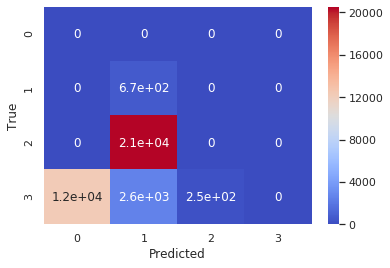

time: 267 ms


In [222]:
sns.heatmap(cmpp3hyp3_03,annot=True,cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('True')

## Change to correct labels

In [223]:
sc1pp3labelshyp3_03
sc1pp3labelshyp3_03[sc1pp3labelshyp3_03 == 0] = 4
sc1pp3labelshyp3_03[sc1pp3labelshyp3_03 == 1] = 5
sc1pp3labelshyp3_03[sc1pp3labelshyp3_03 == 2] = 6

time: 11 ms


In [224]:
sc1pp3labelshyp3_03[sc1pp3labelshyp3_03 == 4] = 2
sc1pp3labelshyp3_03[sc1pp3labelshyp3_03 == 5] = 1
sc1pp3labelshyp3_03[sc1pp3labelshyp3_03 == 6] = 3

time: 12.1 ms


## Check heatmap

In [225]:
cmpp3hyp3_03 = confusion_matrix(target_system.System, sc1pp3labelshyp3_03)

time: 38 ms


In [226]:
cmpp3hyp3_03

array([[  671,     0,     0],
       [20527,     0,     0],
       [ 2615, 12288,   250]])

time: 3.69 ms


Text(30.5, 0.5, 'True')

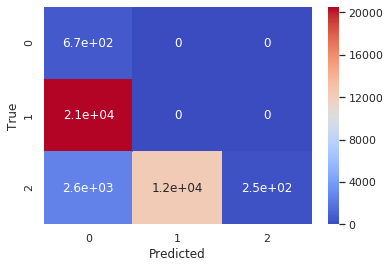

time: 357 ms


In [227]:
sns.heatmap(cmpp3hyp3_03,annot=True,cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('True')

In [228]:
reportpp3hyp3_03 = classification_report(target_system, sc1pp3labelshyp3_03,output_dict = True)

time: 40.9 ms


In [229]:
reportpp3hyp3_03

{'1': {'f1-score': 0.05481130534226433,
  'precision': 0.02817788602863982,
  'recall': 1.0,
  'support': 671},
 '2': {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0, 'support': 20527},
 '3': {'f1-score': 0.032461208855417784,
  'precision': 1.0,
  'recall': 0.016498383158450473,
  'support': 15153},
 'accuracy': 0.025336304365767105,
 'macro avg': {'f1-score': 0.029090838065894038,
  'precision': 0.34272596200954664,
  'recall': 0.33883279438615016,
  'support': 36351},
 'weighted avg': {'f1-score': 0.01454328859373346,
  'precision': 0.4173724893820038,
  'recall': 0.025336304365767105,
  'support': 36351}}

time: 4.16 ms


In [230]:
print("Confusion matrix\n",metrics.confusion_matrix(y_true=target_system.System,y_pred=sc1pp3labelshyp3_03)) 
print("Classification report\n",metrics.classification_report(y_true=target_system.System,y_pred=sc1pp3labelshyp3_03))

Confusion matrix
 [[  671     0     0]
 [20527     0     0]
 [ 2615 12288   250]]
Classification report
               precision    recall  f1-score   support

           1       0.03      1.00      0.05       671
           2       0.00      0.00      0.00     20527
           3       1.00      0.02      0.03     15153

    accuracy                           0.03     36351
   macro avg       0.34      0.34      0.03     36351
weighted avg       0.42      0.03      0.01     36351

time: 78.5 ms


In [231]:
print('\033[1m'+"Kmeans++:"+'\033[0m')
print('\033[1m'+"System 1"+'\033[0m')
print("Precision = {0:0.3f}".format(reportpp3hyp3_03["1"]["precision"]))
print("Recall = {0:0.3f}".format(reportpp3hyp3_03["1"]["recall"]))
print("F1-score = {0:0.3f}".format(reportpp3hyp3_03["1"]["f1-score"]))
print("Support = {0:0.3f}".format(reportpp3hyp3_03["1"]["support"]))
print('\033[1m'+"System 2"+'\033[0m')
print("Precision = {0:0.3f}".format(reportpp3hyp3_03["2"]["precision"]))
print("Recall = {0:0.3f}".format(reportpp3hyp3_03["2"]["recall"]))
print("F1-score = {0:0.3f}".format(reportpp3hyp3_03["2"]["f1-score"]))
print("Support = {0:0.3f}".format(reportpp3hyp3_03["2"]["support"]))
print('\033[1m'+"System 3"+'\033[0m')
print("Precision = {0:0.3f}".format(reportpp3hyp3_03["3"]["precision"]))
print("Recall = {0:0.3f}".format(reportpp3hyp3_03["3"]["recall"]))
print("F1-score = {0:0.3f}".format(reportpp3hyp3_03["3"]["f1-score"]))
print("Support = {0:0.3f}".format(reportpp3hyp3_03["3"]["support"]))

Kmeans++:
System 1
Precision = 0.028
Recall = 1.000
F1-score = 0.055
Support = 671.000
System 2
Precision = 0.000
Recall = 0.000
F1-score = 0.000
Support = 20527.000
System 3
Precision = 1.000
Recall = 0.016
F1-score = 0.032
Support = 15153.000
time: 16 ms


In [232]:
print('\033[1m'+'Clustering metrics - supervised'+'\033[0m')
print('Adjusted Rand score: ', metrics.adjusted_rand_score(target_system.System, sc1pp3labelshyp3_03))
print('Mutual info score: ', metrics.adjusted_mutual_info_score(target_system.System, sc1pp3labelshyp3_03))
print('Homogeneity score: ', metrics.homogeneity_score(target_system.System, sc1pp3labelshyp3_03))
print('Completeness score: ', metrics.completeness_score(target_system.System, sc1pp3labelshyp3_03))
print('V-measure: ', metrics.v_measure_score(target_system.System, sc1pp3labelshyp3_03))
print('Fowlkes-Mallows score: ', metrics.fowlkes_mallows_score(target_system.System, sc1pp3labelshyp3_03))

Clustering metrics - supervised
Adjusted Rand score:  0.6823361077431518
Mutual info score:  0.6288415438002335
Homogeneity score:  0.5945082951466247
Completeness score:  0.6674481883802669
V-measure:  0.6288703132831919
Fowlkes-Mallows score:  0.8475658942266868
time: 64.2 ms


In [233]:
print('\033[1m'+'Clustering metrics - unsupervised'+'\033[0m')
print('Silhouette: ',metrics.silhouette_score(dfsc1, sc1pp3labelshyp3_03, metric='euclidean'))
print('Davies-Bouldin Index: ',metrics.davies_bouldin_score(dfsc1, sc1pp3labelshyp3_03))
print('Calinski-Harabasz Index: ',metrics.calinski_harabaz_score(dfsc1, sc1pp3labelshyp3_03))

Clustering metrics - unsupervised
Silhouette:  0.7988472575098736
Davies-Bouldin Index:  0.2191686775955013
Calinski-Harabasz Index:  226688.89004129928
time: 16.7 s


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.
  warnings.warn(msg, category=FutureWarning)


# 4 Visualize data with PCA

In [234]:
# Visualize the results on PCA-reduced data

reduced_data = PCA(n_components=2).fit_transform(dfsc1)
kmeans = KMeans(init='k-means++', n_clusters=3, n_init=100)
kmeans.fit(reduced_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=100, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

time: 1.66 s


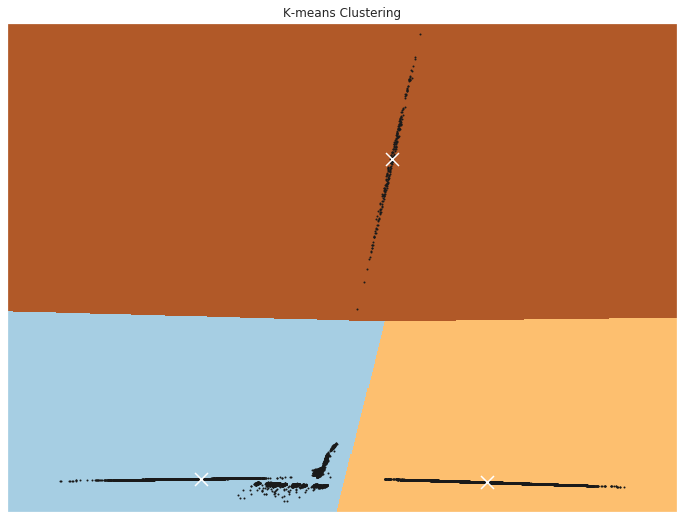

time: 493 ms


In [235]:
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
#plt.figure(1)
plt.figure(figsize = (12,9))
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
#plt.title('K-means Clustering on the supply chain dataset (PCA-reduced data)\n'
 #         'Centroids are marked with white cross')
plt.title('K-means Clustering')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

# 5. Comparison of all models and scenarios

- tables on excel (metrics analysis)

- heatmaps in small format separately

- analyze all results and what changes for each metric, each cluster x category, and conclude what should be done when using this technique, if it should be used, how it can be improved, etc --> paper